In [1]:
import os
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
import re
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 300

try:
    experiment_folder = os.environ['AZEBAN_EXPERIMENT_DIR']
except:
    experiment_folder = '/home/tobias/Programmieren/azeban/build'

In [2]:
def _scale_up(u, N):
    n = u.shape[-1]
    nf = n // 2 + 1
    u_hat_small = np.fft.rfftn(u, axes=(1, 2, 3), norm='forward')
    u_hat_big = np.zeros((3, N, N, N//2+1), dtype=u_hat_small.dtype)
    u_hat_big[:,:nf,:nf,:nf] = u_hat_small[:,:nf,:nf,:nf]
    u_hat_big[:,:nf,-nf:,:nf] = u_hat_small[:,:nf,-nf:,:nf]
    u_hat_big[:,-nf:,:nf,:nf] = u_hat_small[:,-nf:,:nf,:nf]
    u_hat_big[:,-nf:,-nf:,:nf] = u_hat_small[:,-nf:,-nf:,:nf]
    u_scaled = np.fft.irfftn(u_hat_big, s=(N, N, N), axes=(1, 2, 3), norm='forward')
    return u_scaled

def read_u(path, sample, time, N=None):
    with nc.Dataset(f'{path}/sample_{sample}_time_{time}.nc', 'r') as f:
        N_loc = f.dimensions['N'].size
        u = np.empty((3, N_loc, N_loc, N_loc))
        u[0,:,:,:] = f['u'][:,:,:]
        u[1,:,:,:] = f['v'][:,:,:]
        u[2,:,:,:] = f['w'][:,:,:]
    if N is None:
        return u
    else:
        return _scale_up(u, N)

def u_mean(path, time, N=None, samples=None):
    files = os.listdir(path)
    reg = re.compile(f'^sample_\\d+_time_{time}.nc$')
    u_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in u_files]))))
    mean = read_u(path, samples[0], time, N=N)
    for sample in samples[1:]:
        mean += read_u(path, sample, time, N=N)
    return mean / len(samples)

def u_variance(path, time, N=None, mean=None, samples=None):
    if mean is None:
        mean = u_mean(path, time, N=N, samples=samples)
    files = os.listdir(path)
    reg = re.compile(f'^sample_\\d+_time_{time}.nc$')
    u_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in u_files]))))
    var = np.zeros_like(mean)
    for sample in samples:
        u = read_u(path, sample, time, N=N)
        var += (u - mean)**2
    return var / (len(samples) - 1)

In [3]:
def plot_mean(paths, Ns, time, p=2, save_name=None, samples=None):
    mean_ref = u_mean(paths[-1], time, samples=samples)
    ref_norm = np.sum(mean_ref**p)**(1/p)
    errs = []
    for path,N in zip(paths[:-1], Ns[:-1]):
        mean = u_mean(path, time, N=Ns[-1], samples=samples)
        err = np.sum((mean_ref - mean)**p)**(1/p)
        errs.append(err / ref_norm)
    plt.loglog(Ns[:-1], errs)
    plt.xlabel('N')
    plt.ylabel(f'$\\frac{{\\|\\bar{{u}}_N-\\bar{{u}}_0\\|_{{L^{{{p}}}}}}}{{\\|\\bar{{u}}_0\\|_{{L^{{{p}}}}}}}$')
    plt.title(f'$L^{{{p}}}$-error of mean')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    
def plot_variance(paths, Ns, time, p=2, save_name=None, samples=None):
    variance_ref = u_variance(paths[-1], time, samples)
    ref_norm = np.sum(variance_ref**p)**(1/p)
    errs = []
    for path,N in zip(paths[:-1], Ns[:-1]):
        var = u_variance(path, time, N=Ns[-1], samples=samples)
        err = np.sum((variance_ref - var)**p)**(1/p)
        errs.append(err / ref_norm)
    plt.loglog(Ns[:-1], errs)
    plt.xlabel('N')
    plt.ylabel(f'$\\frac{{\\|Var(u_N)-Var(u_0)\\|_{{L^{{{p}}}}}}}{{\\|Var(u_0)\\|_{{L^{{{p}}}}}}}$')
    plt.title(f'$L^{{{p}}}$-error of variance')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

# Convergence of Brownian Bridges

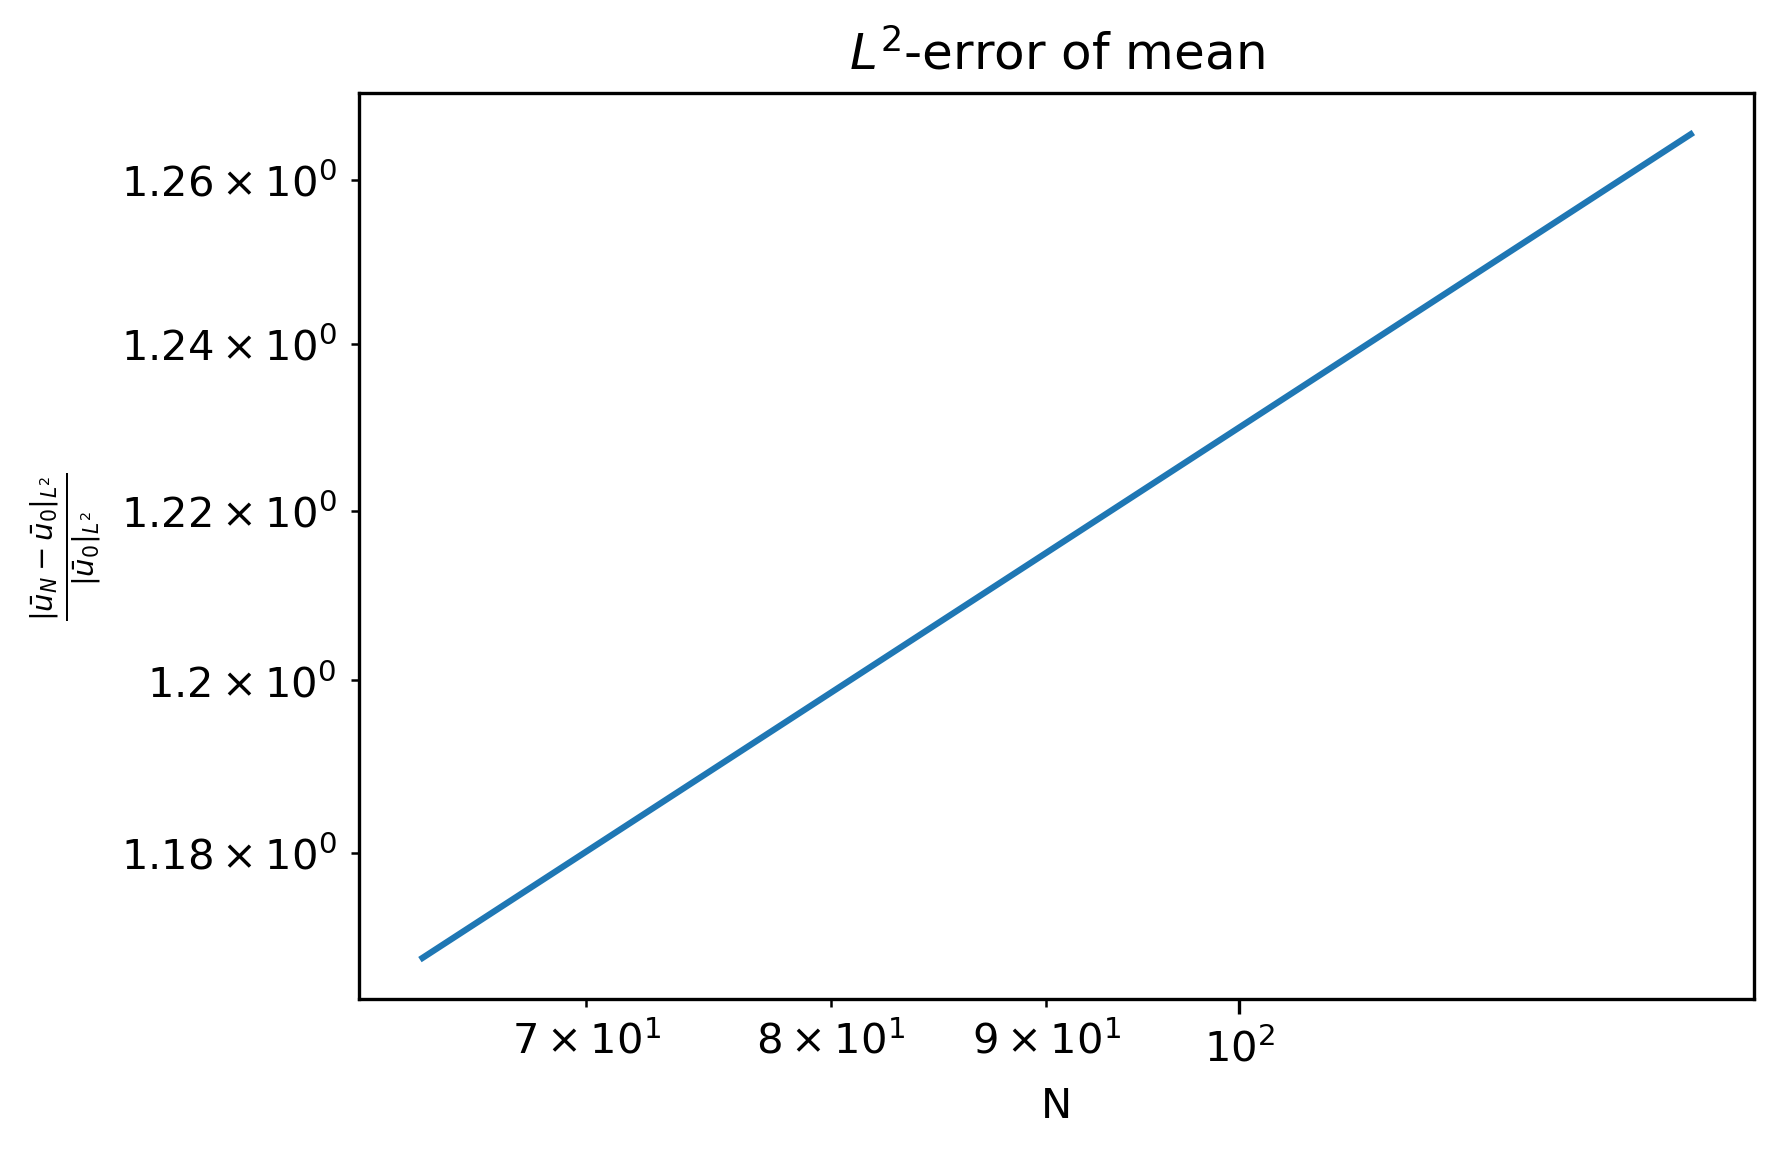

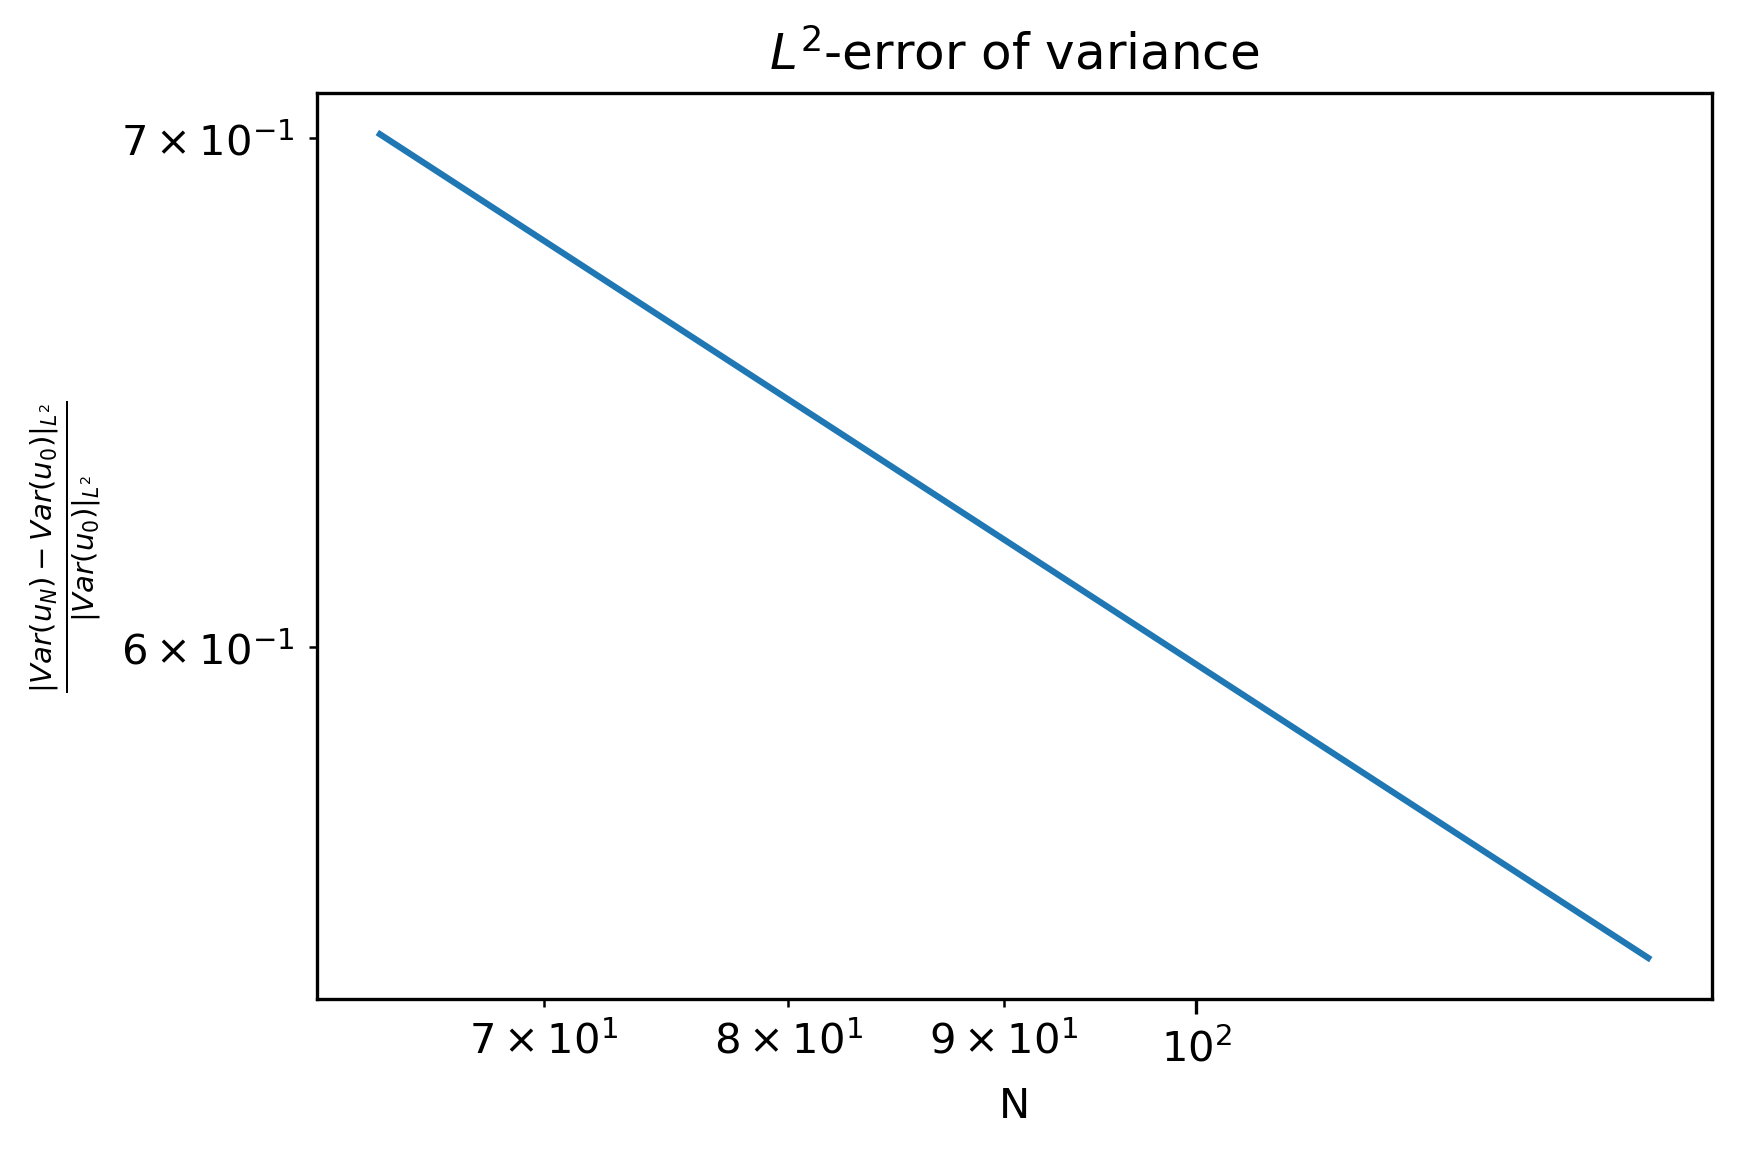

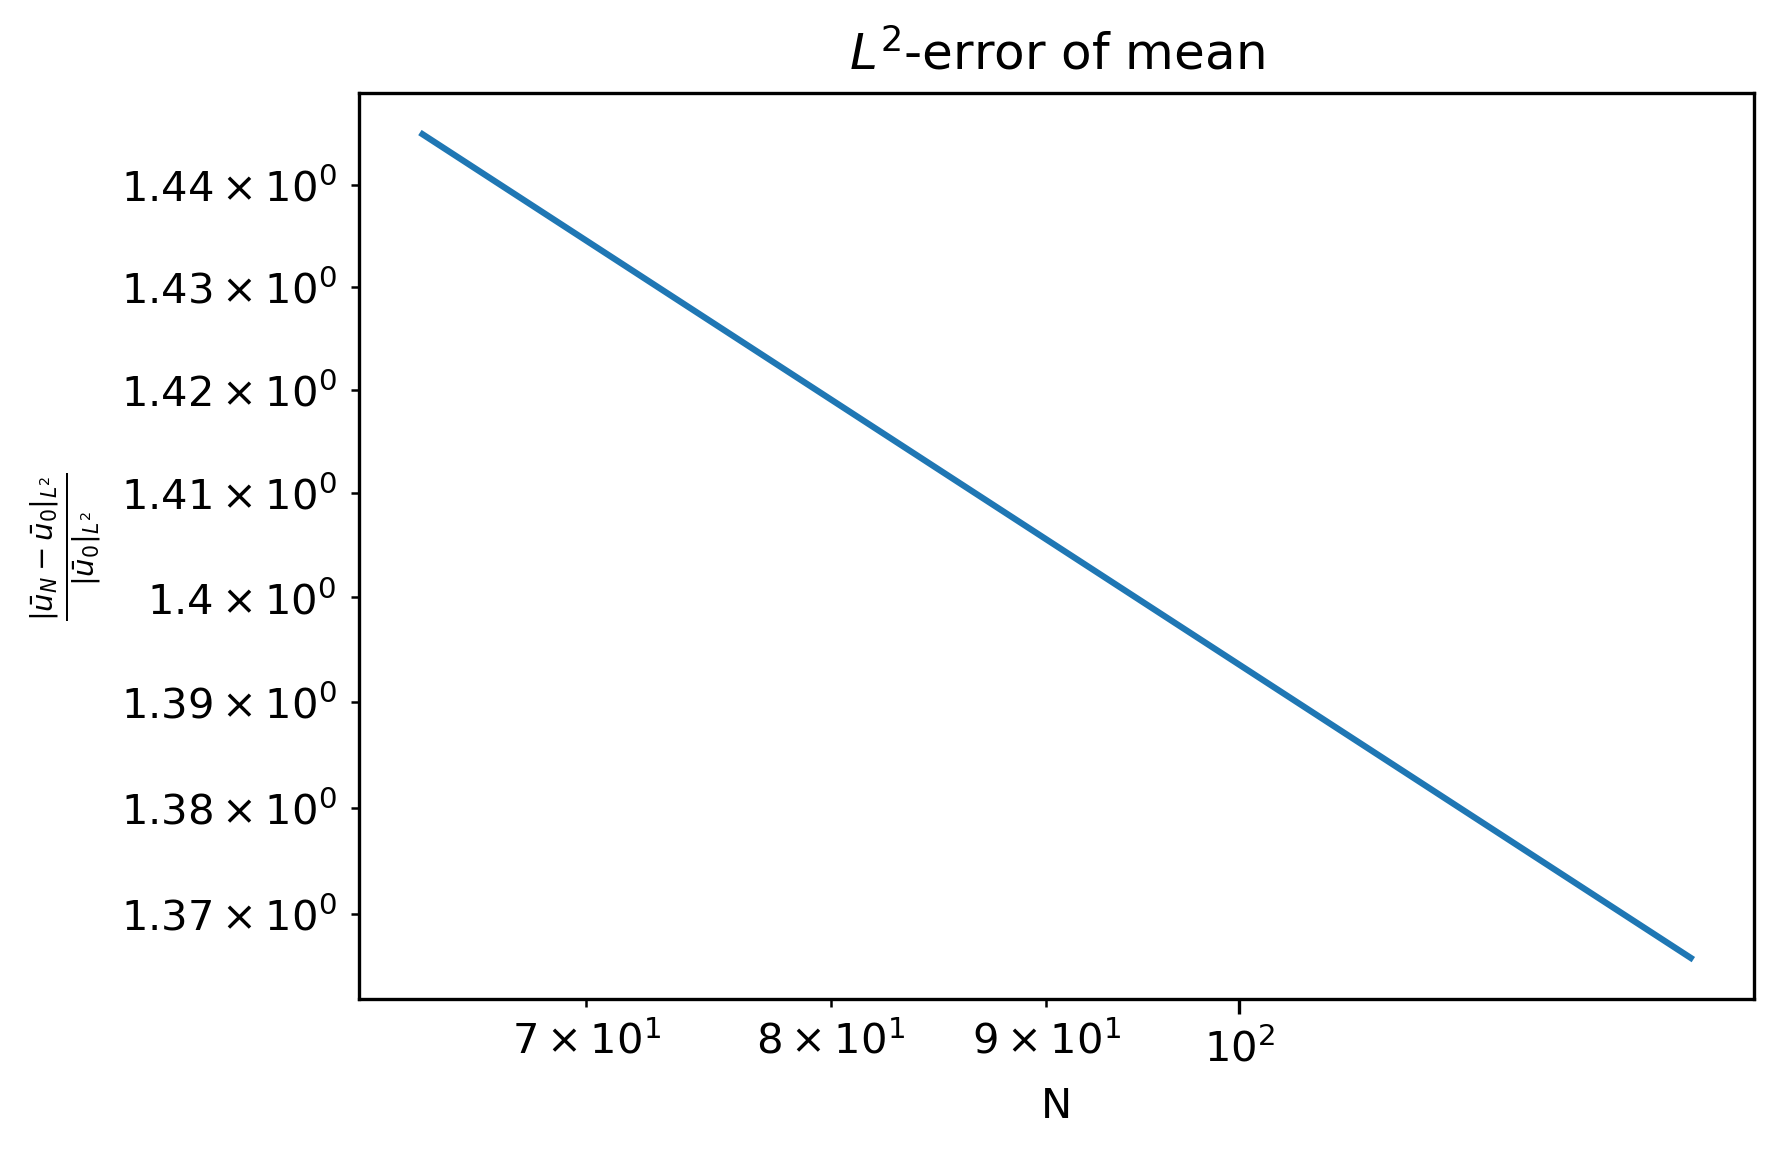

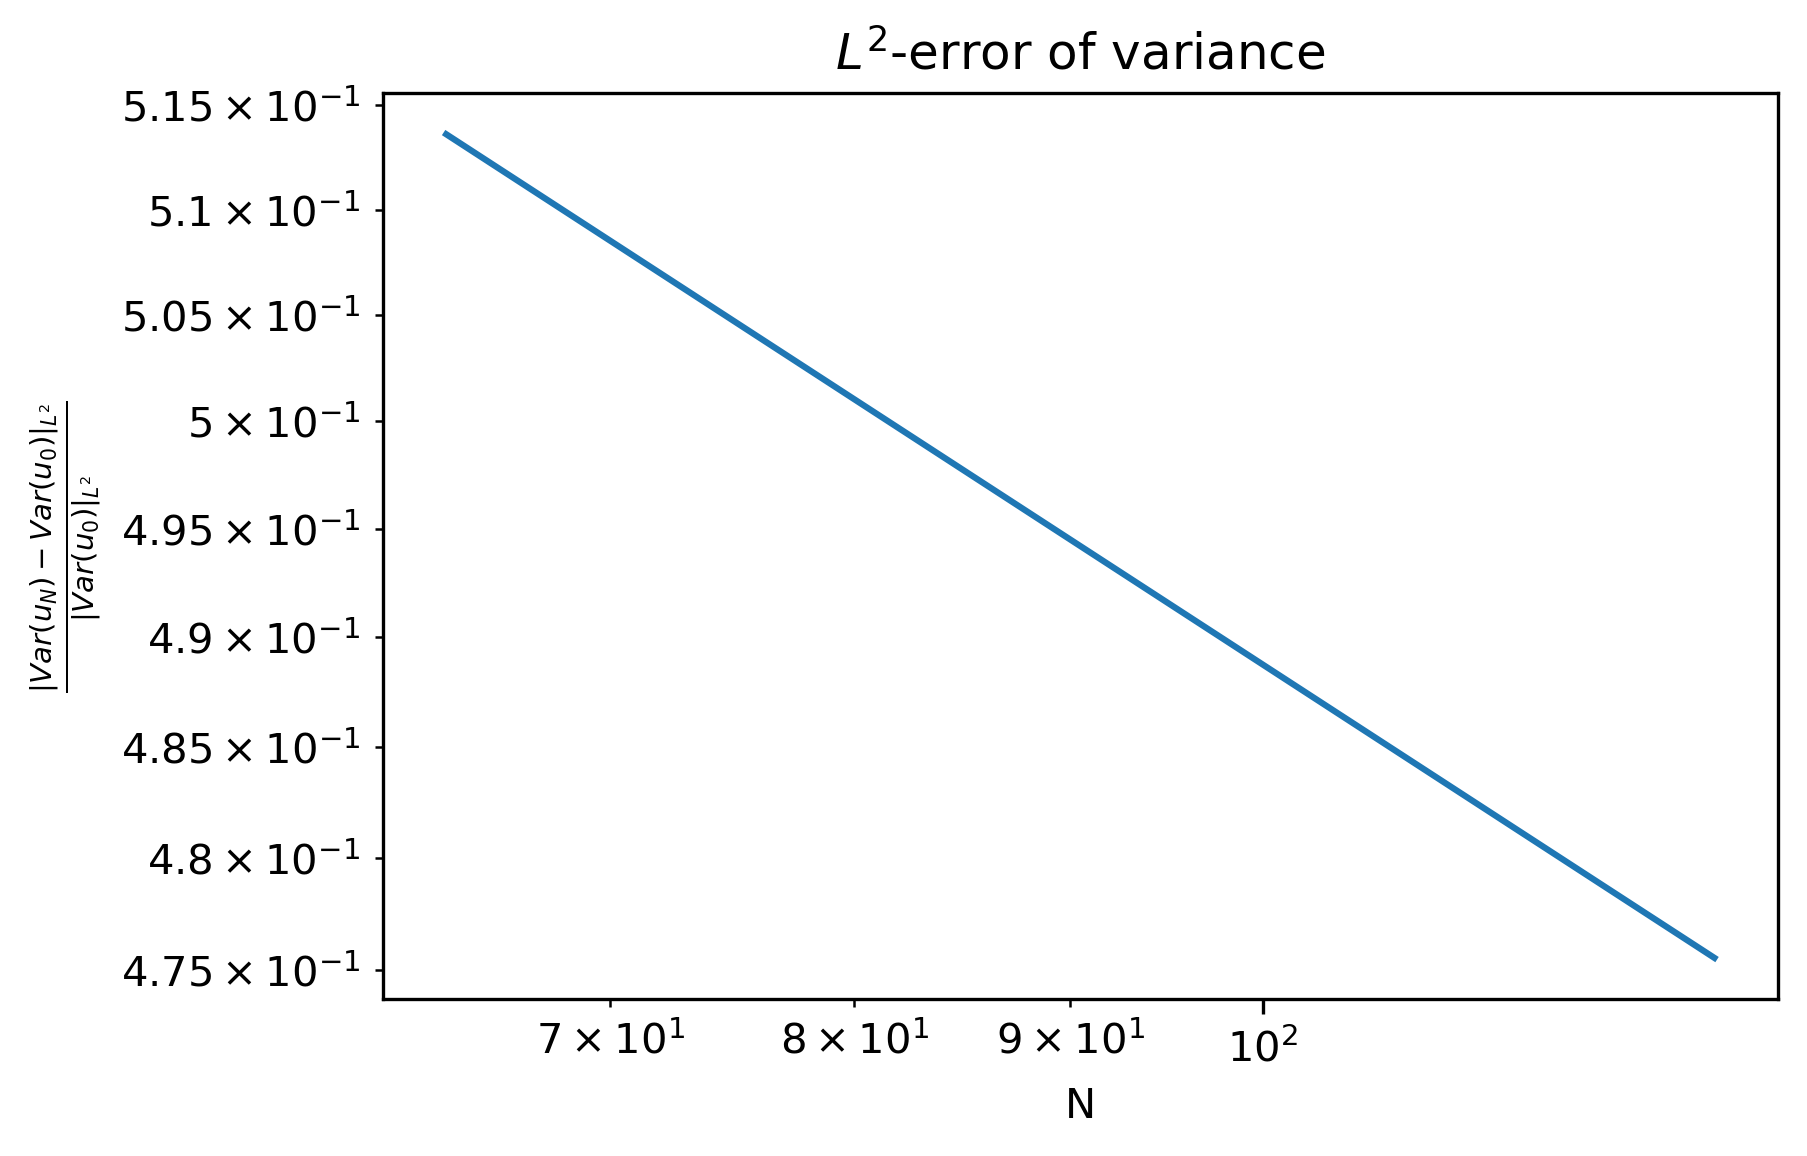

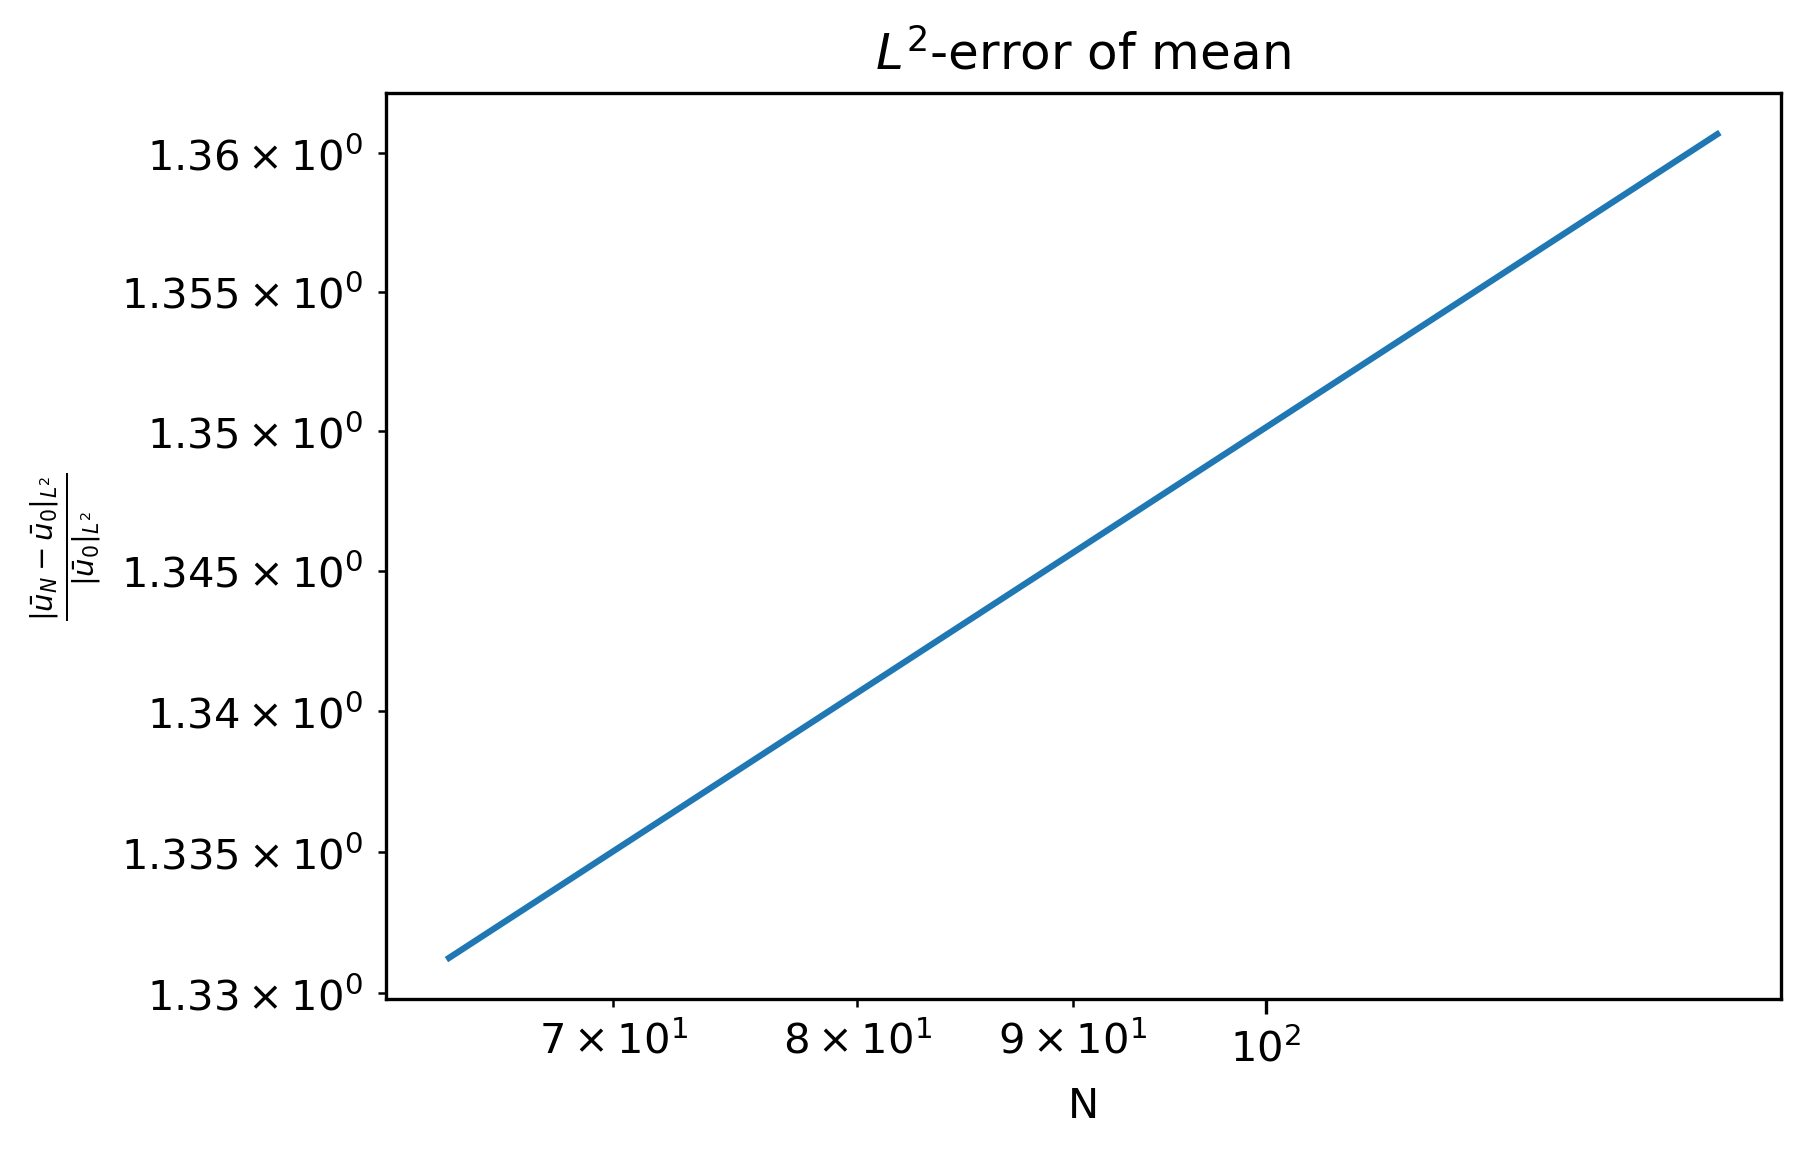

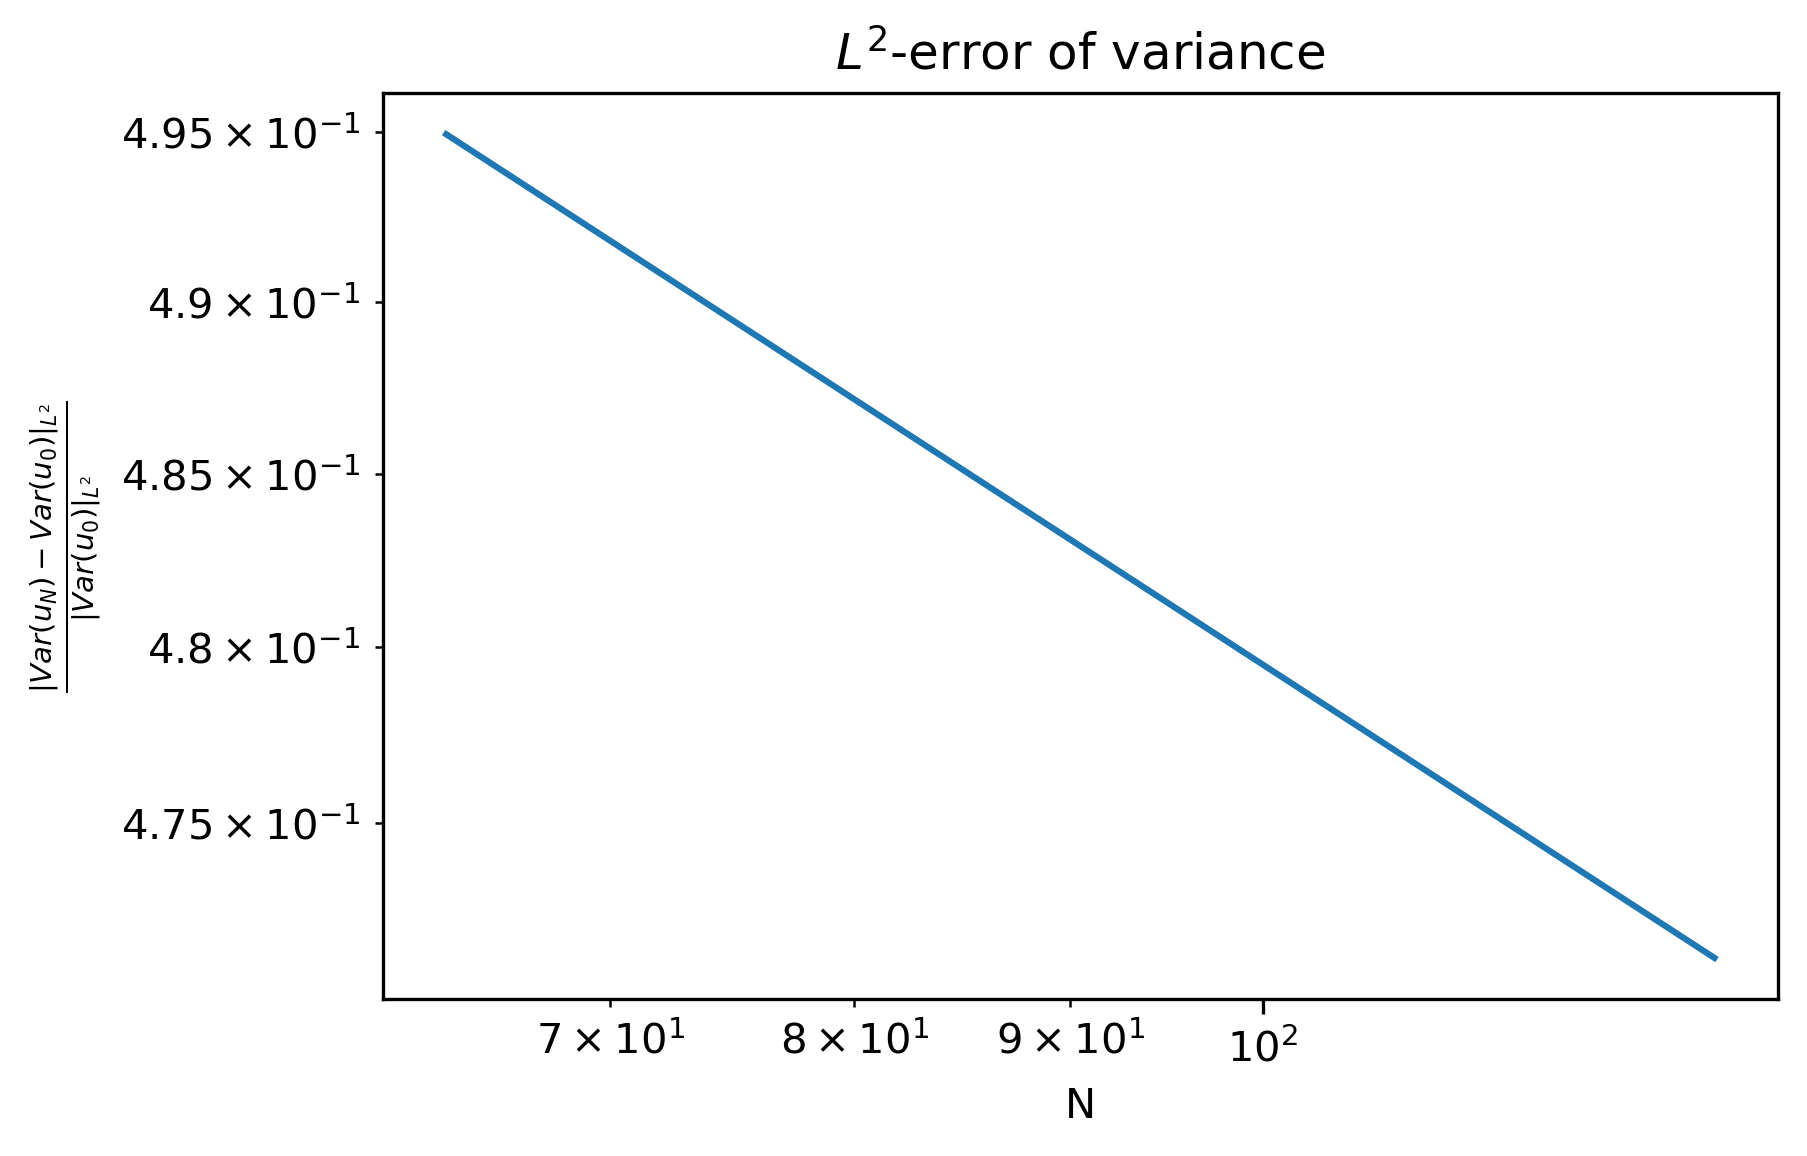

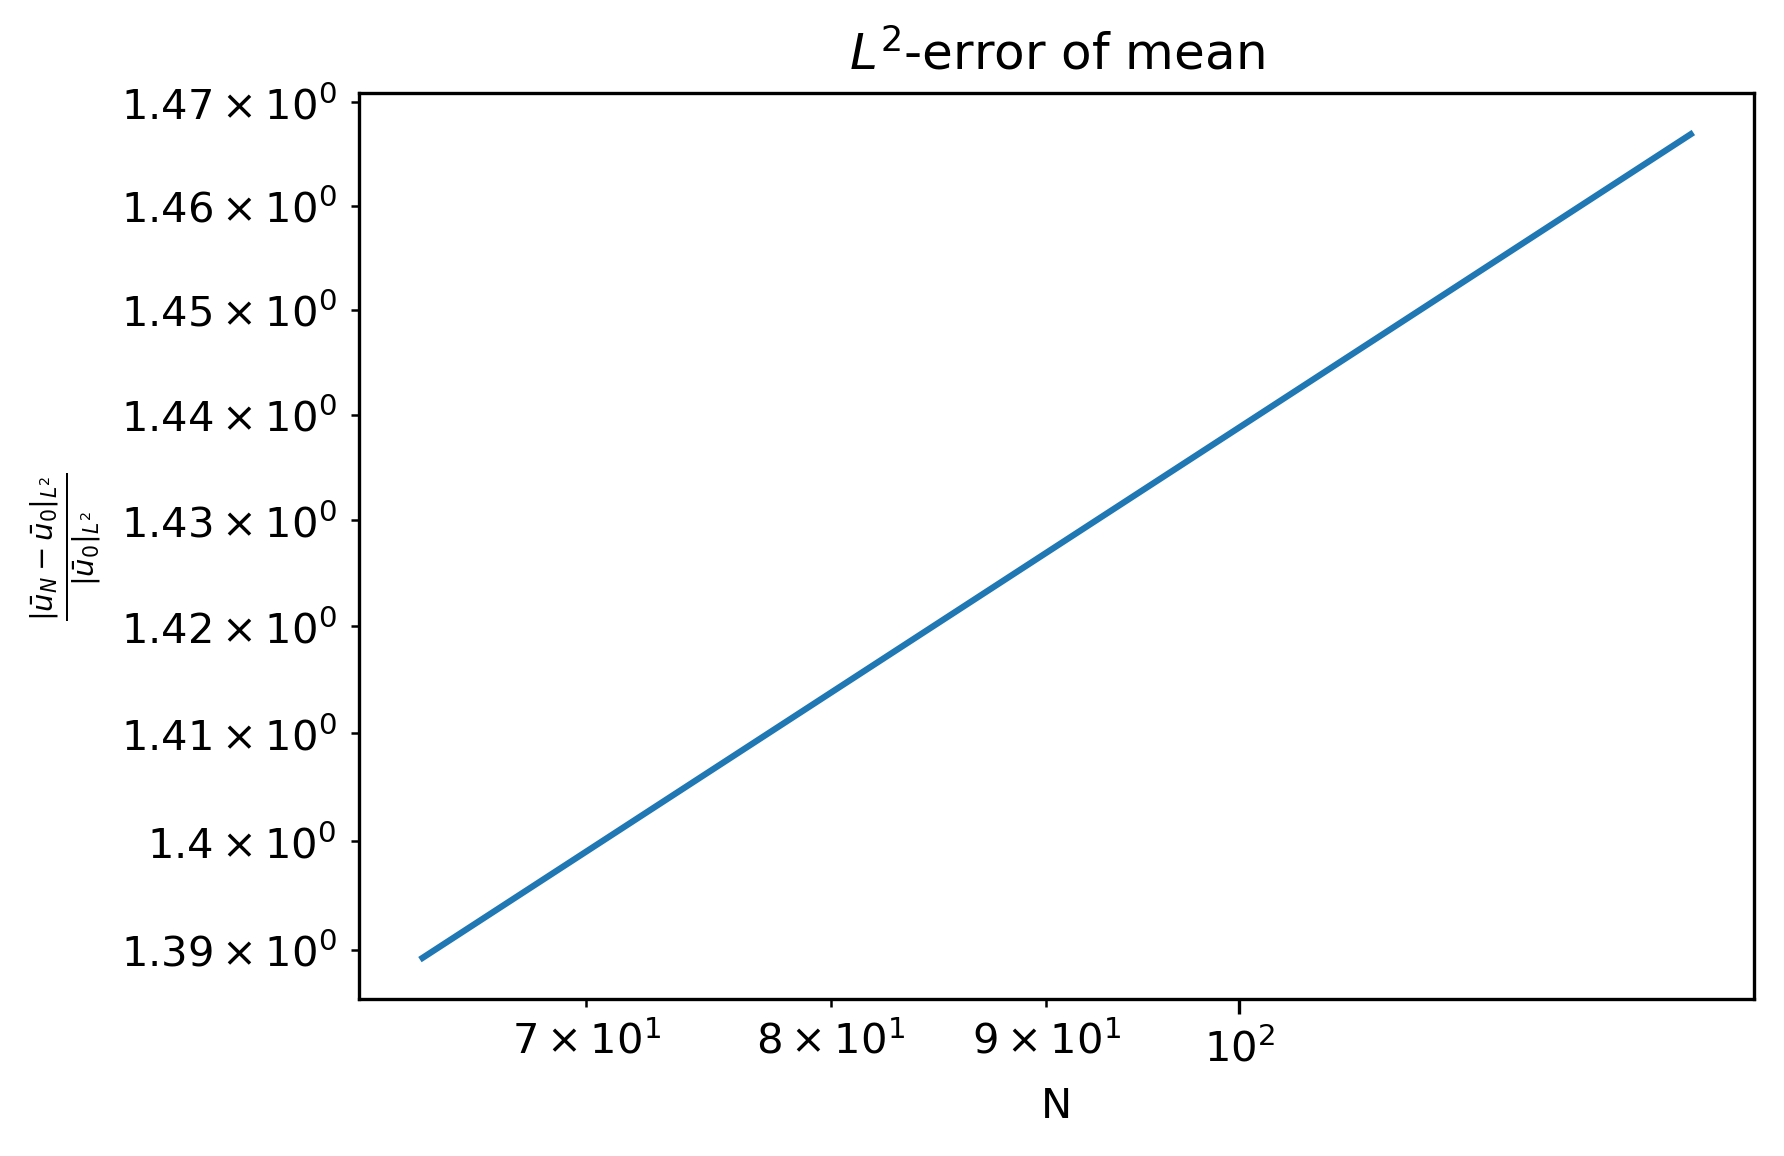

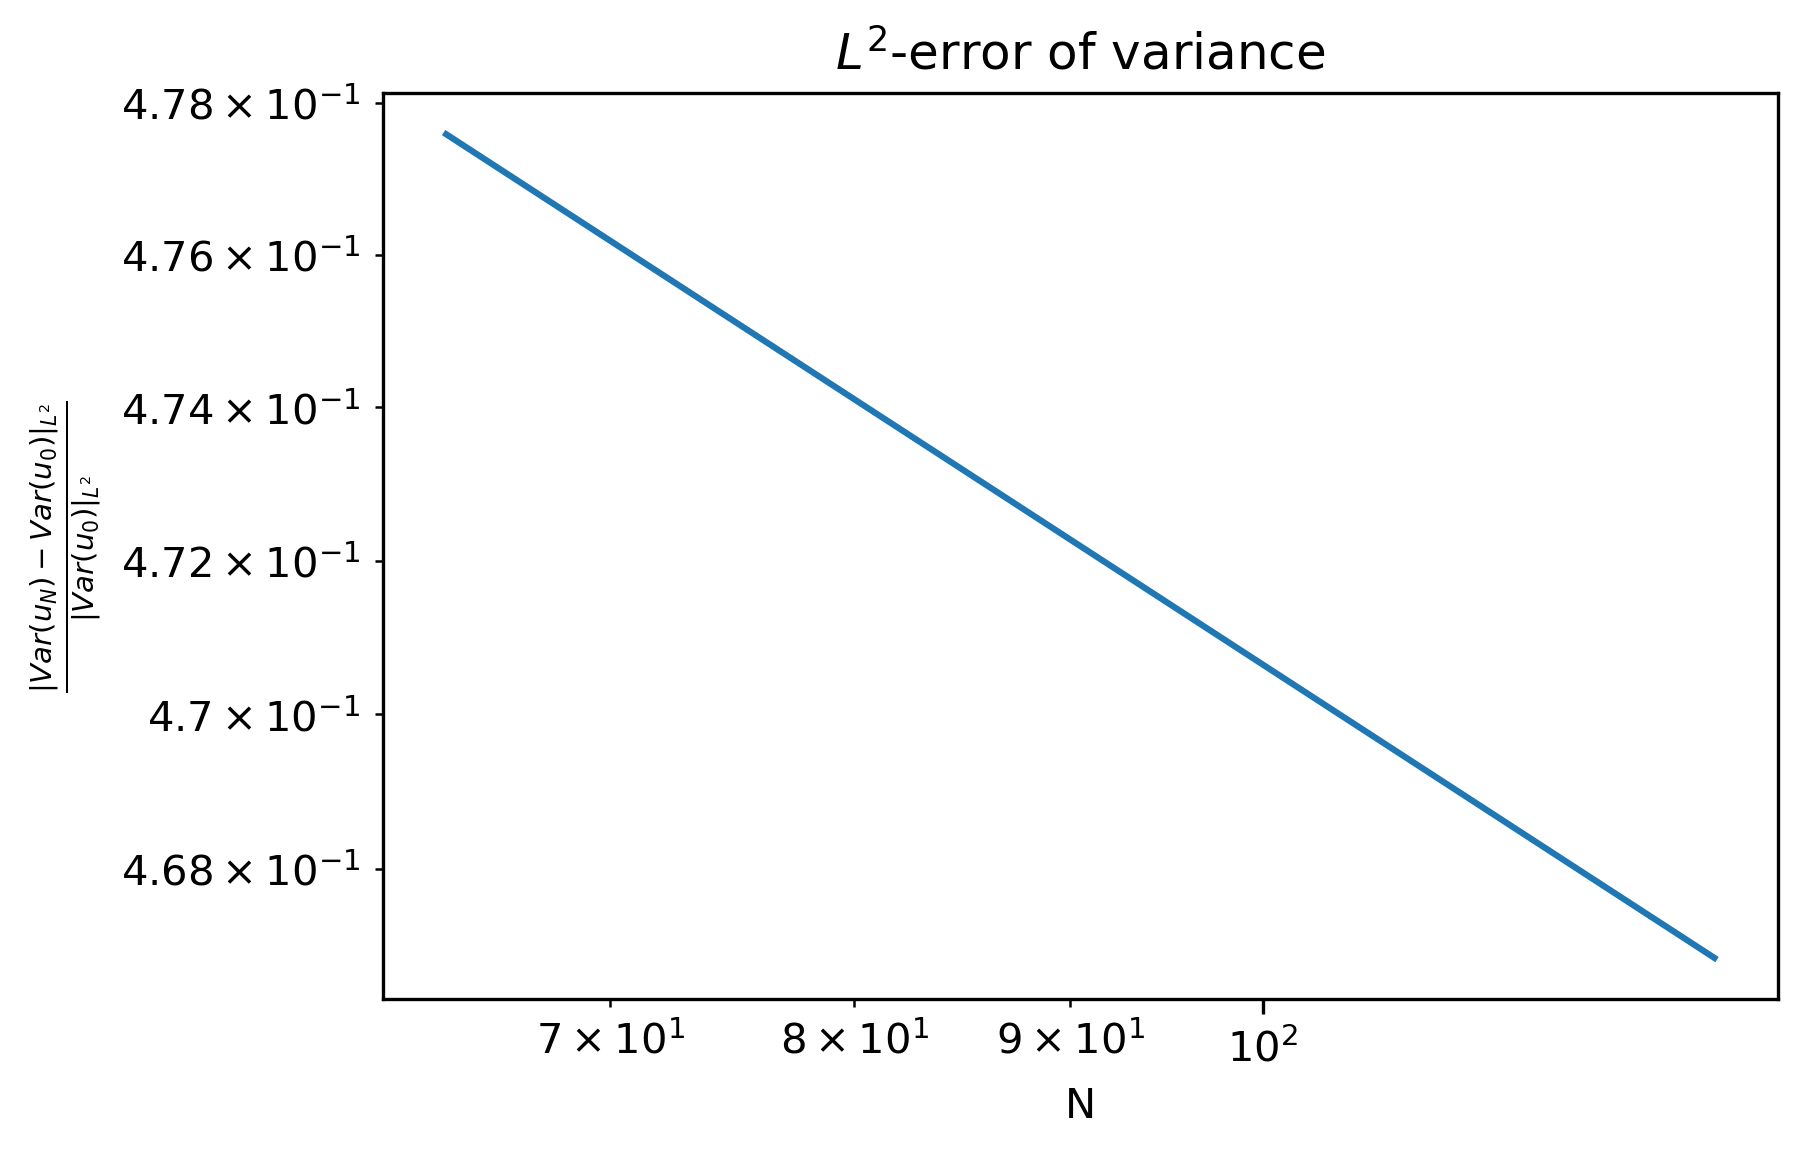

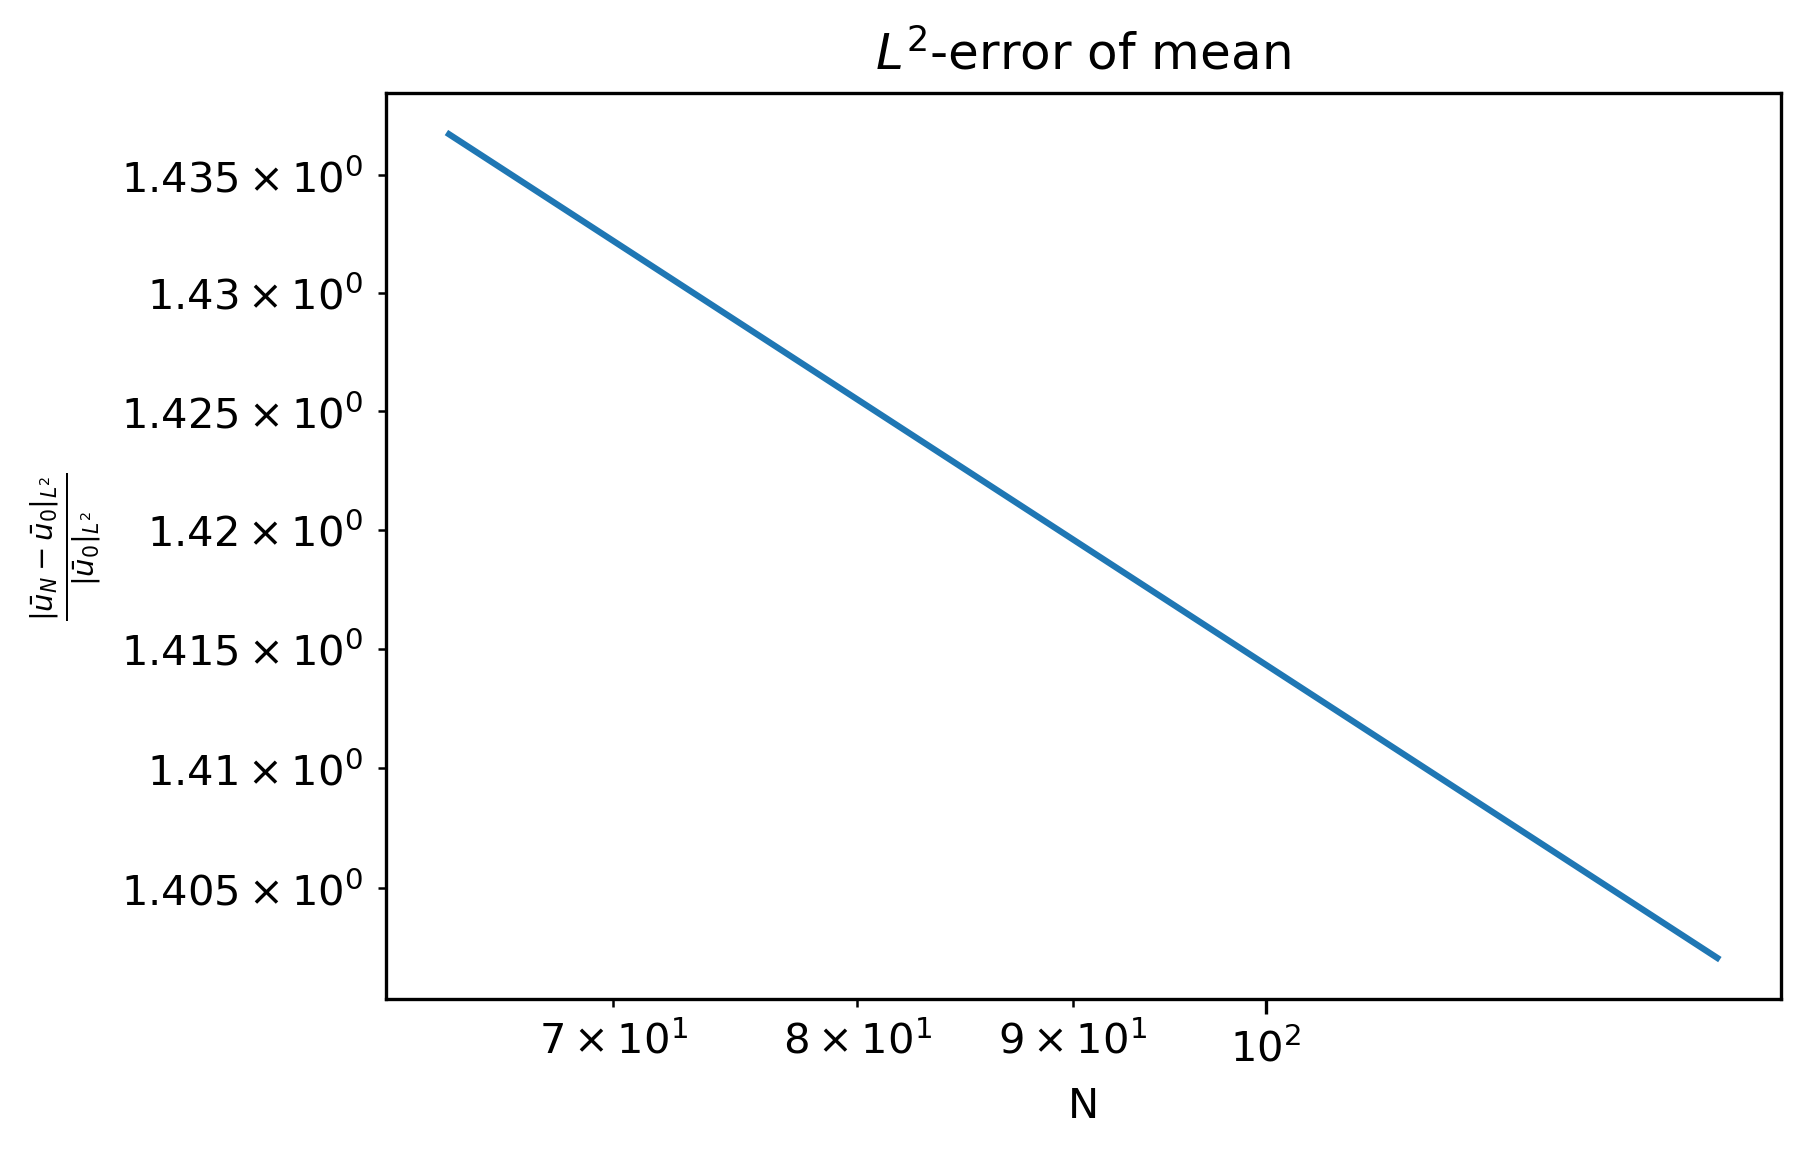

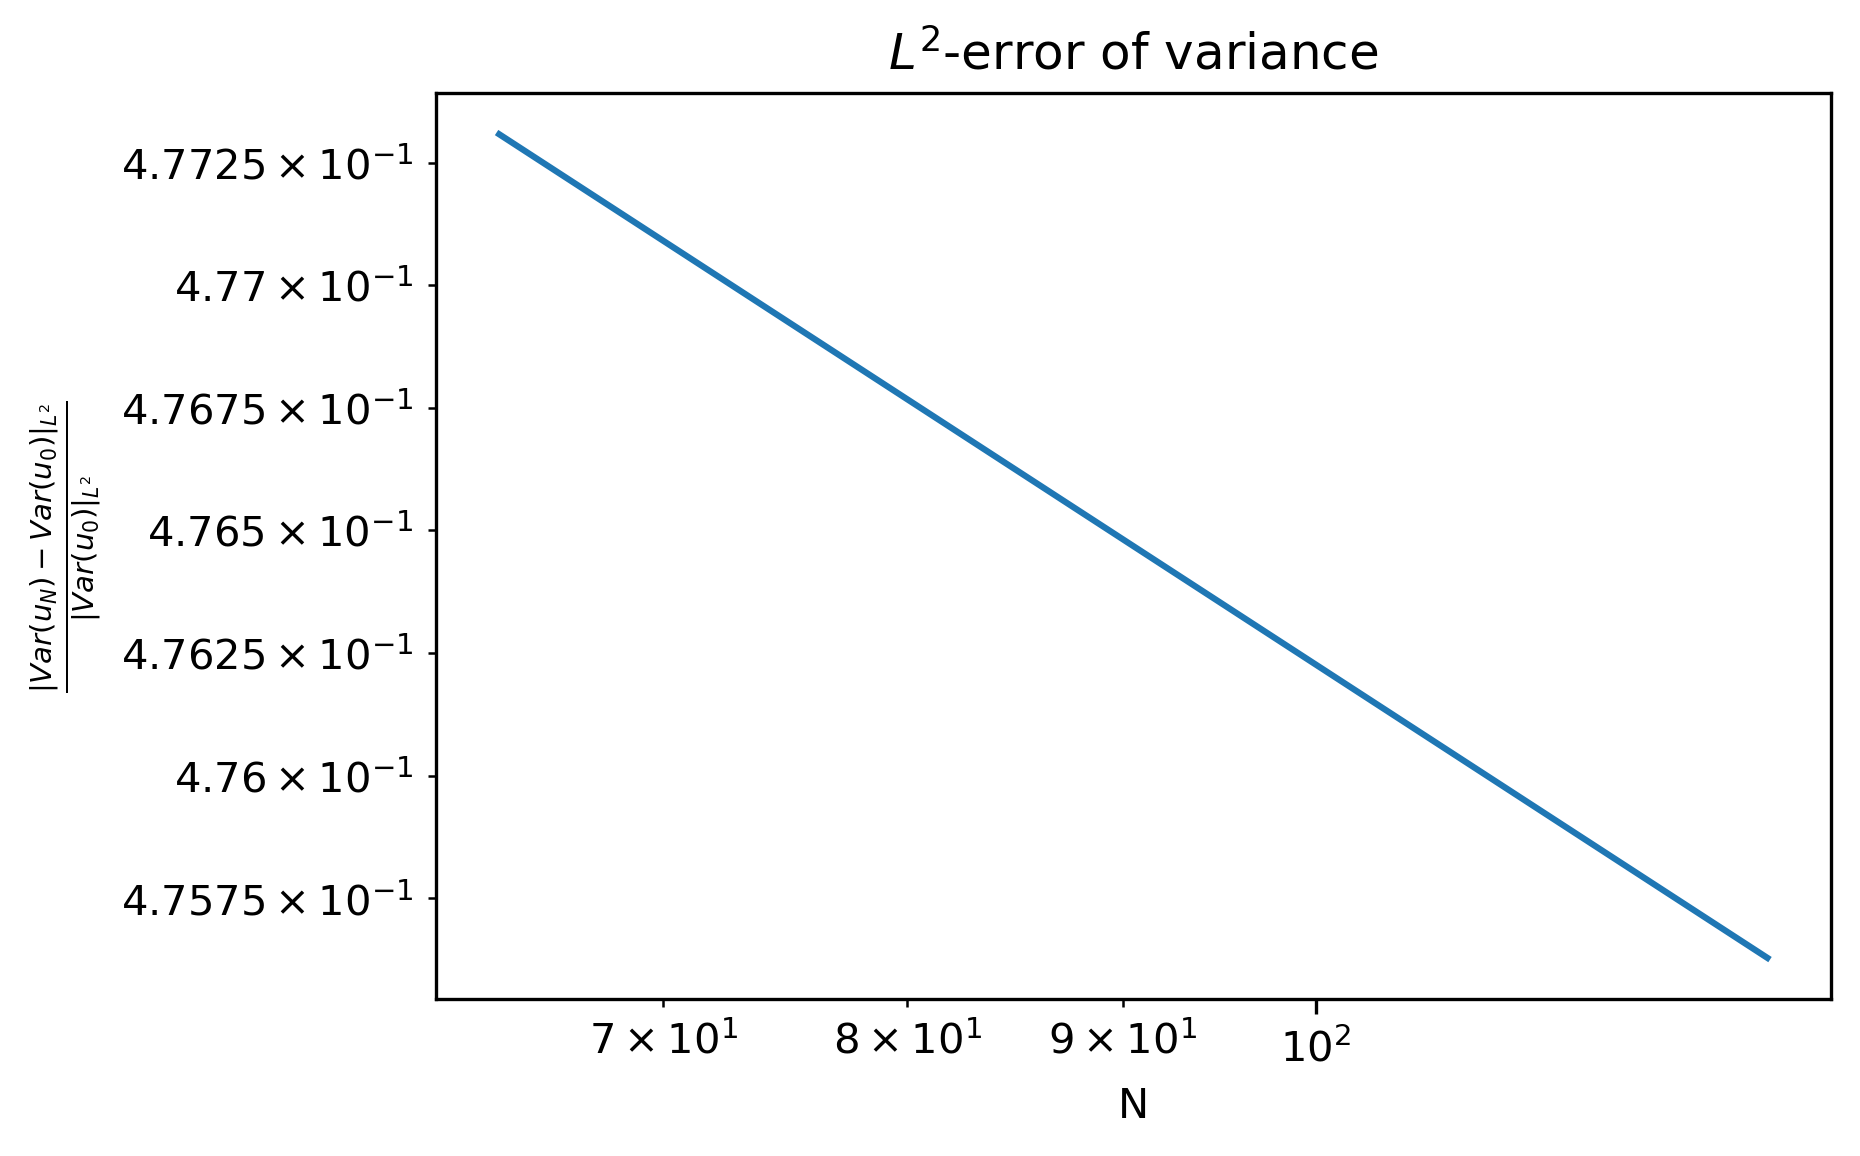

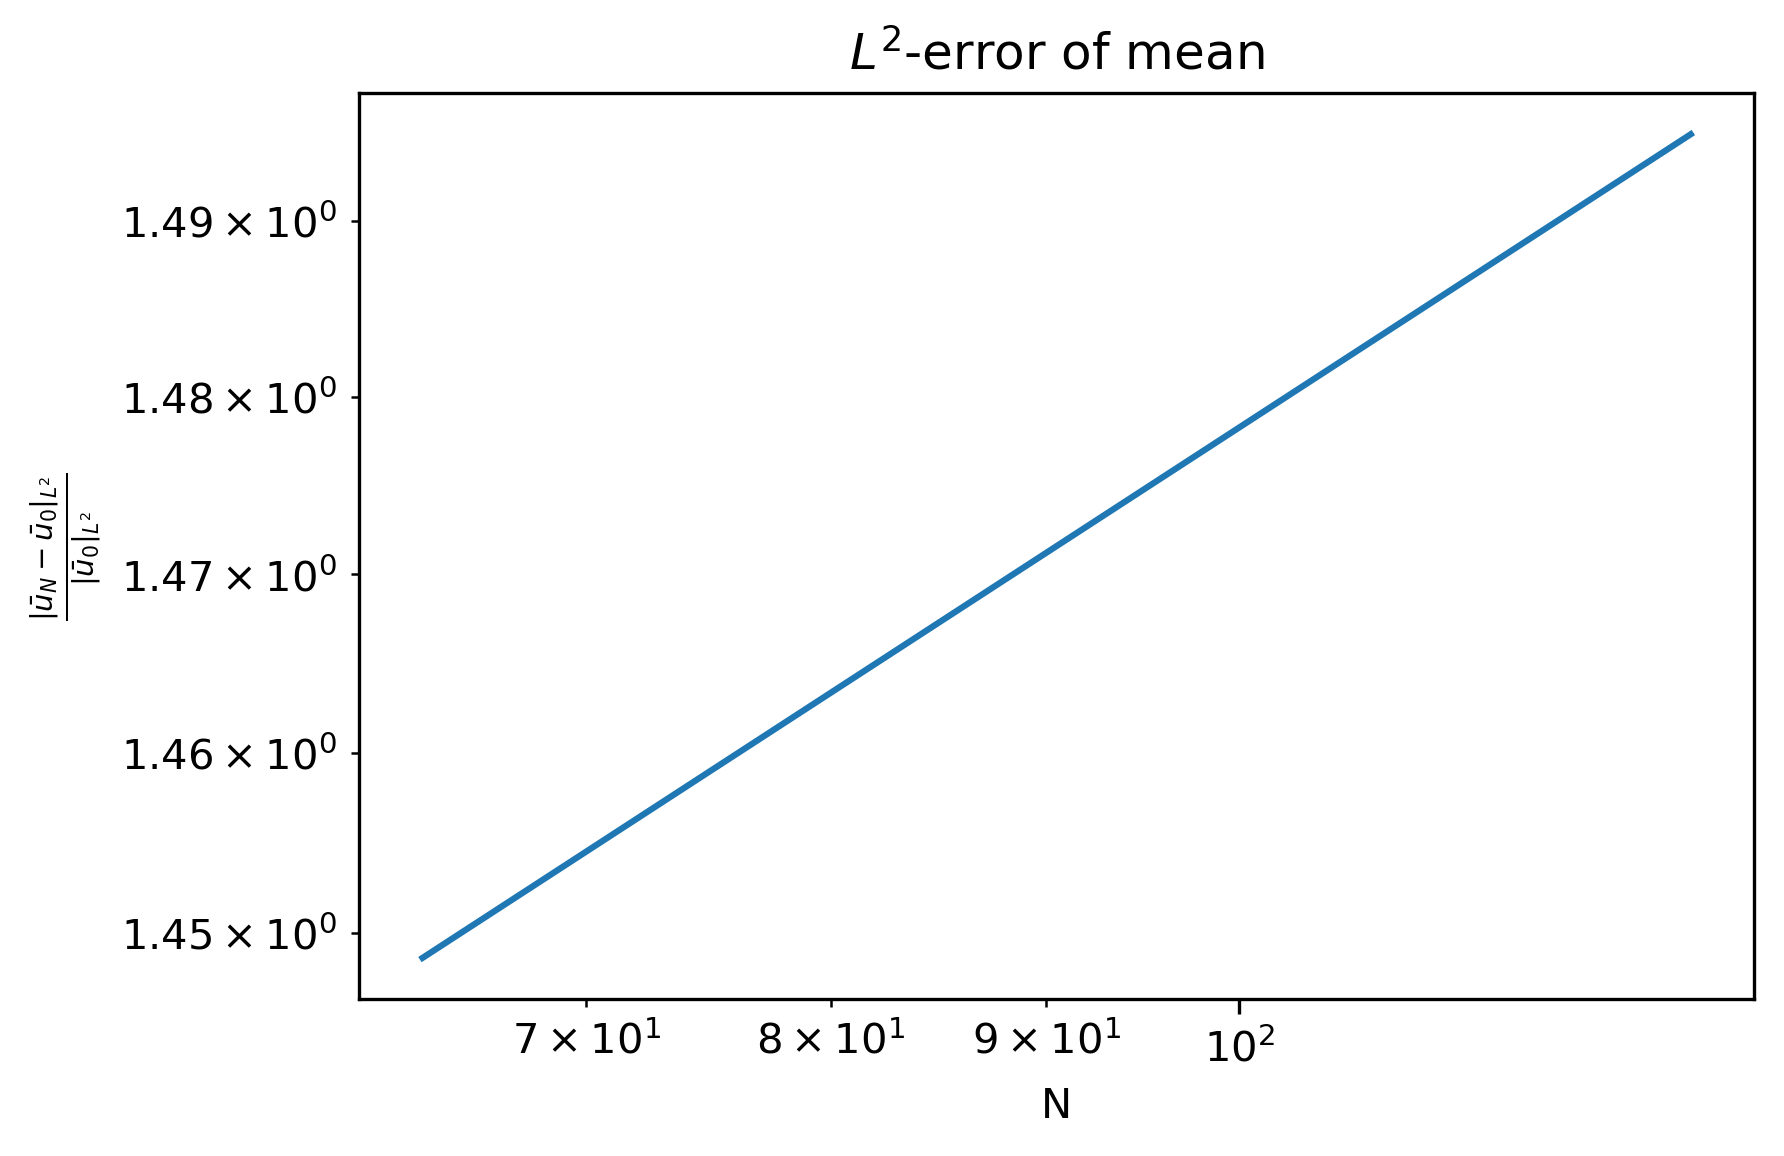

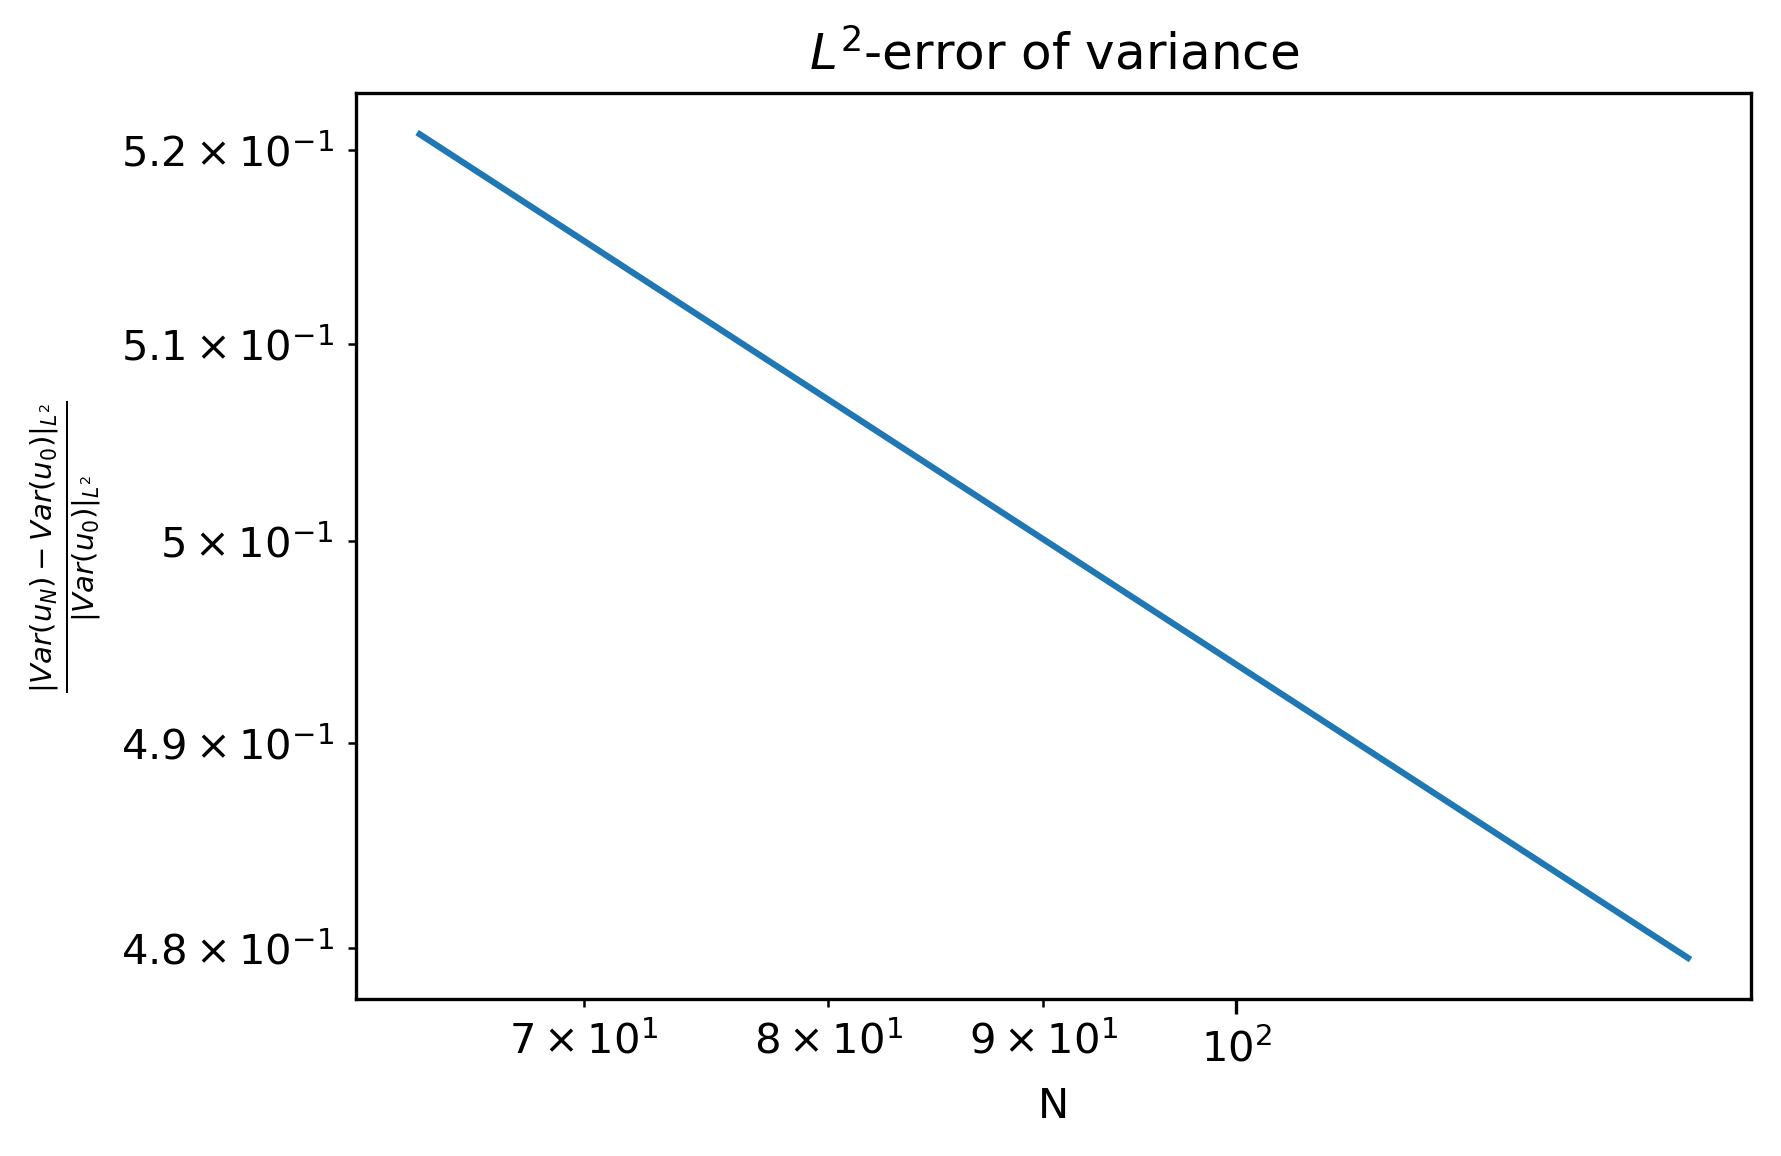

In [4]:
for H in [15, 50, 75]:
    plot_mean([f'{experiment_folder}/bm_H{H}_N64',
               f'{experiment_folder}/bm_H{H}_N128',
               f'{experiment_folder}/bm_H{H}_N256'],
              [64, 128, 256], 0,
              save_name=f'{experiment_folder}/bm_H{H}_convergence_mean_t0.png')
    plot_variance([f'{experiment_folder}/bm_H{H}_N64',
                   f'{experiment_folder}/bm_H{H}_N128',
                   f'{experiment_folder}/bm_H{H}_N256'],
                  [64, 128, 256], 0,
                  save_name=f'{experiment_folder}/bm_H{H}_convergence_variance_t0.png')
    plot_mean([f'{experiment_folder}/bm_H{H}_N64',
               f'{experiment_folder}/bm_H{H}_N128',
               f'{experiment_folder}/bm_H{H}_N256'],
              [64, 128, 256], 20,
              save_name=f'{experiment_folder}/bm_H{H}_convergence_mean_t2.png')
    plot_variance([f'{experiment_folder}/bm_H{H}_N64',
                   f'{experiment_folder}/bm_H{H}_N128',
                   f'{experiment_folder}/bm_H{H}_N256'],
                  [64, 128, 256], 20,
                  save_name=f'{experiment_folder}/bm_H{H}_convergence_variance_t2.png')

# Convergence of Taylor-Green Vortex

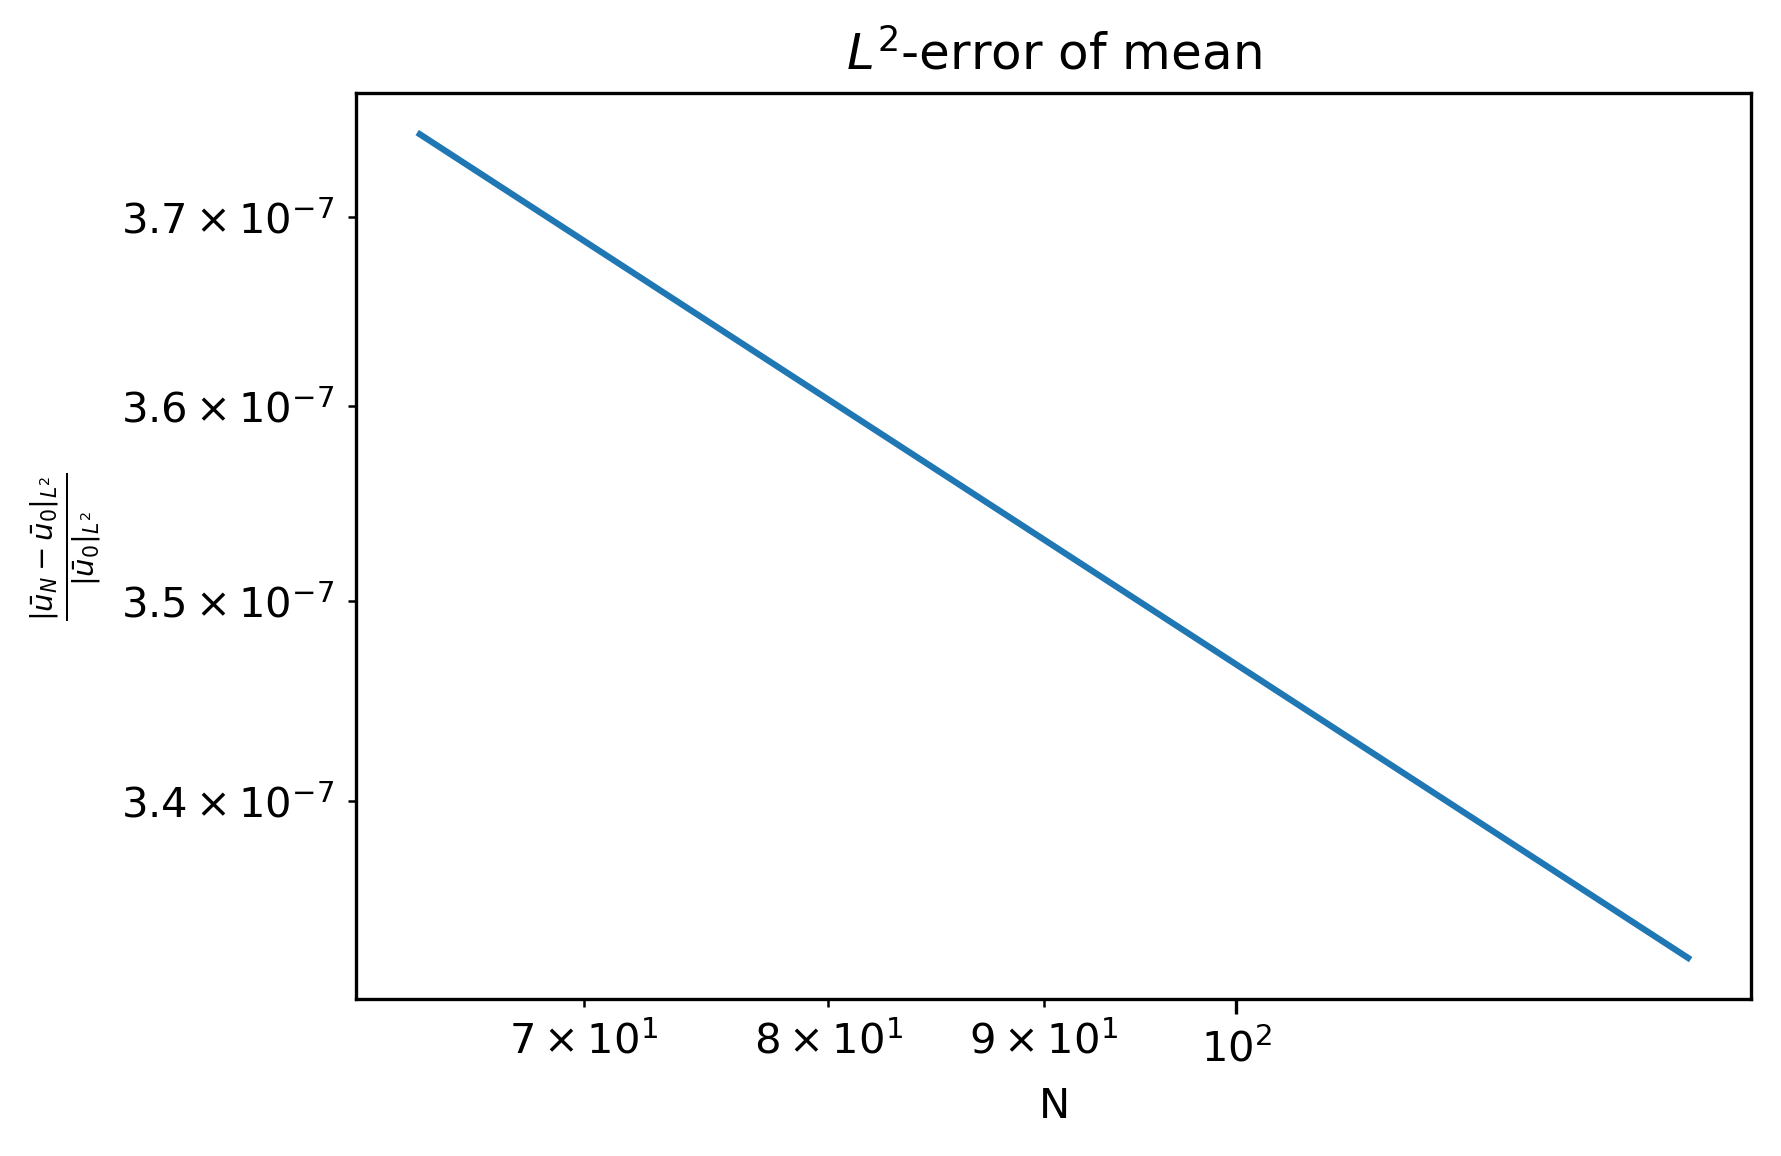

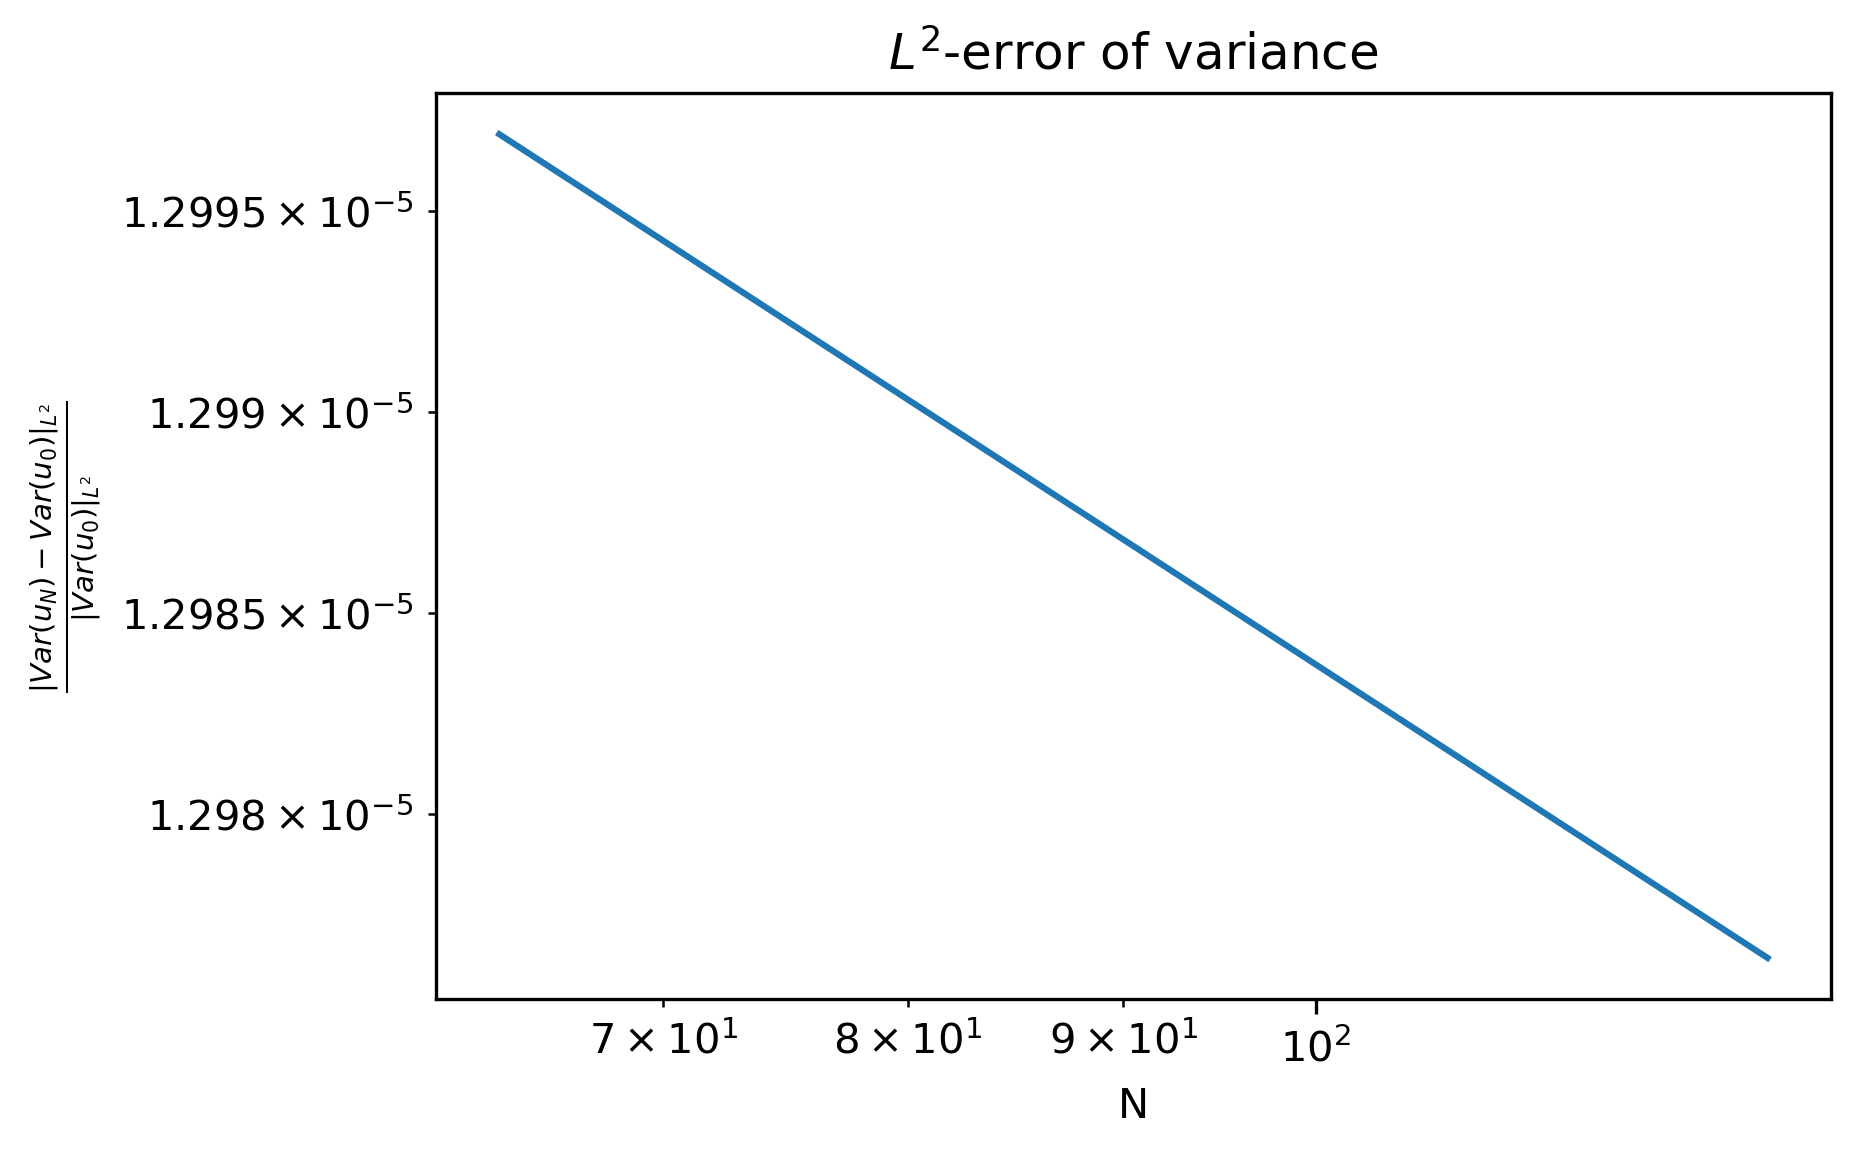

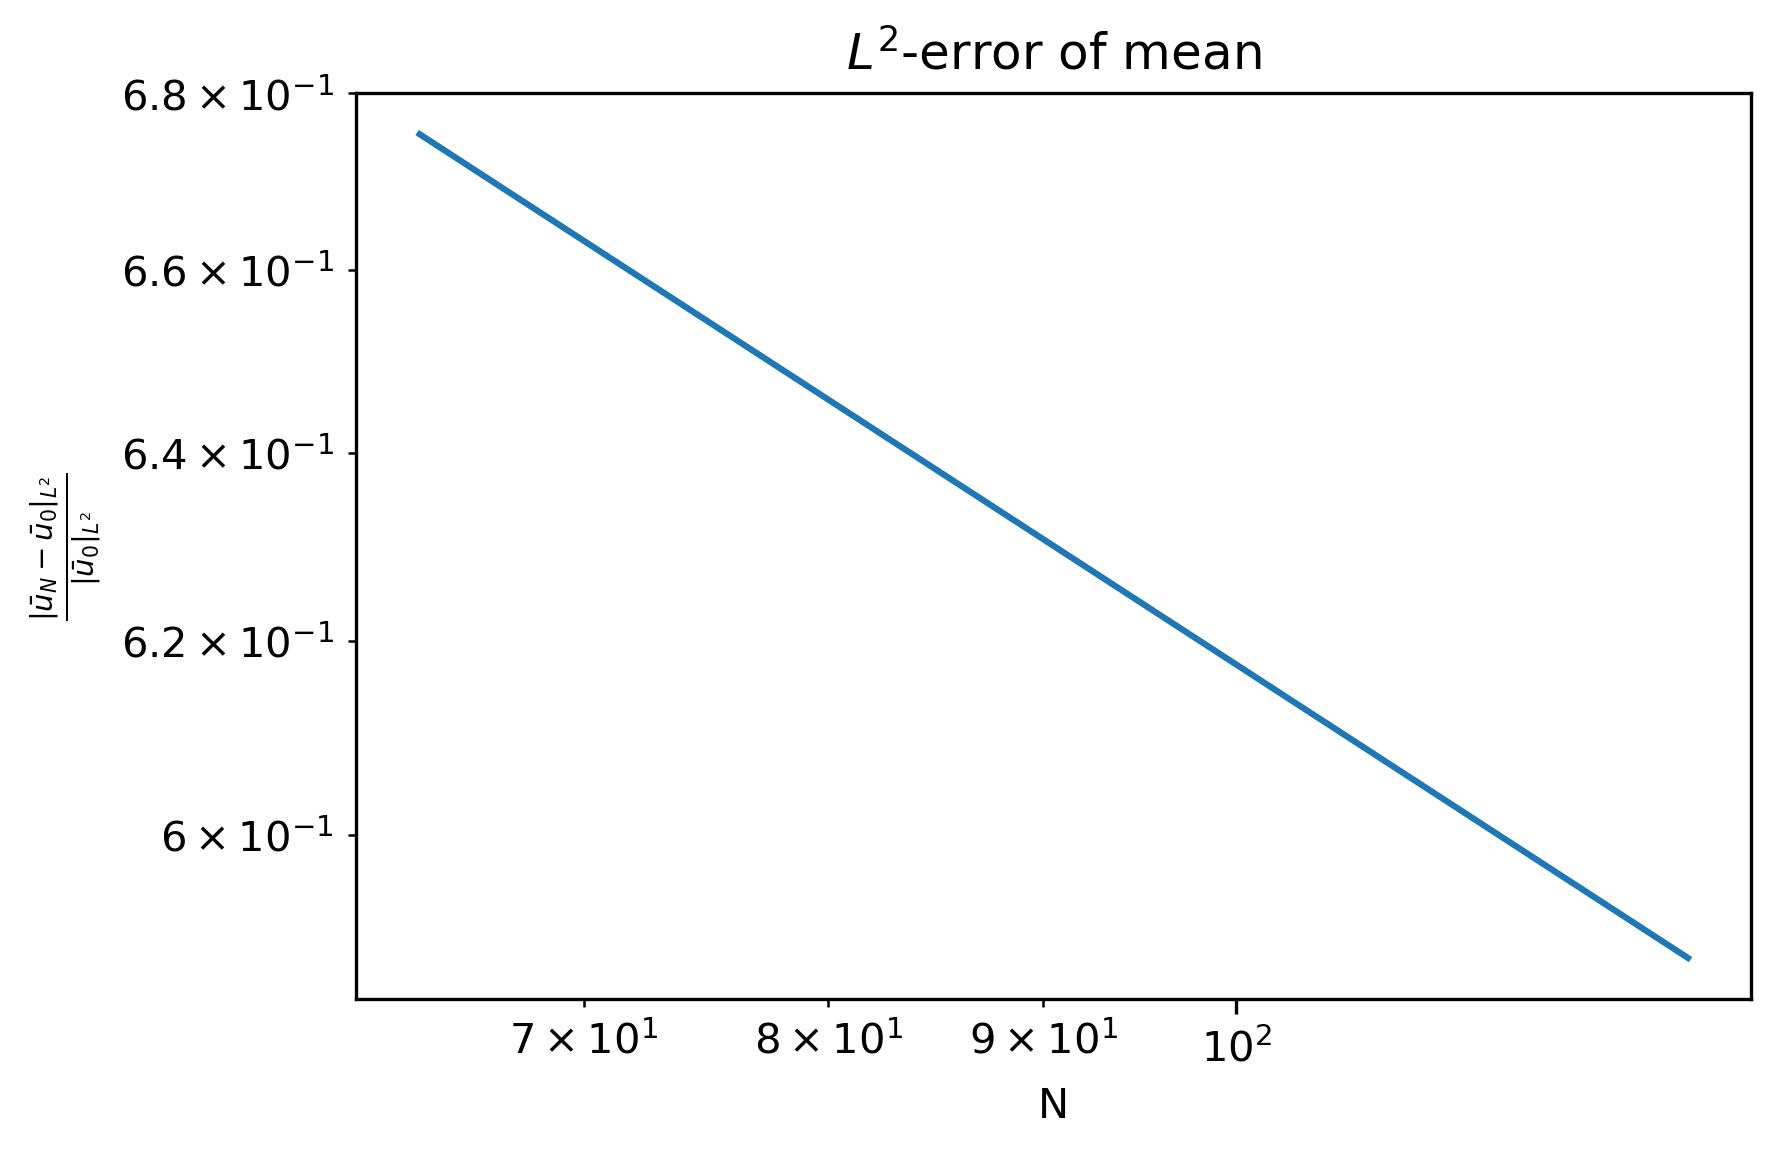

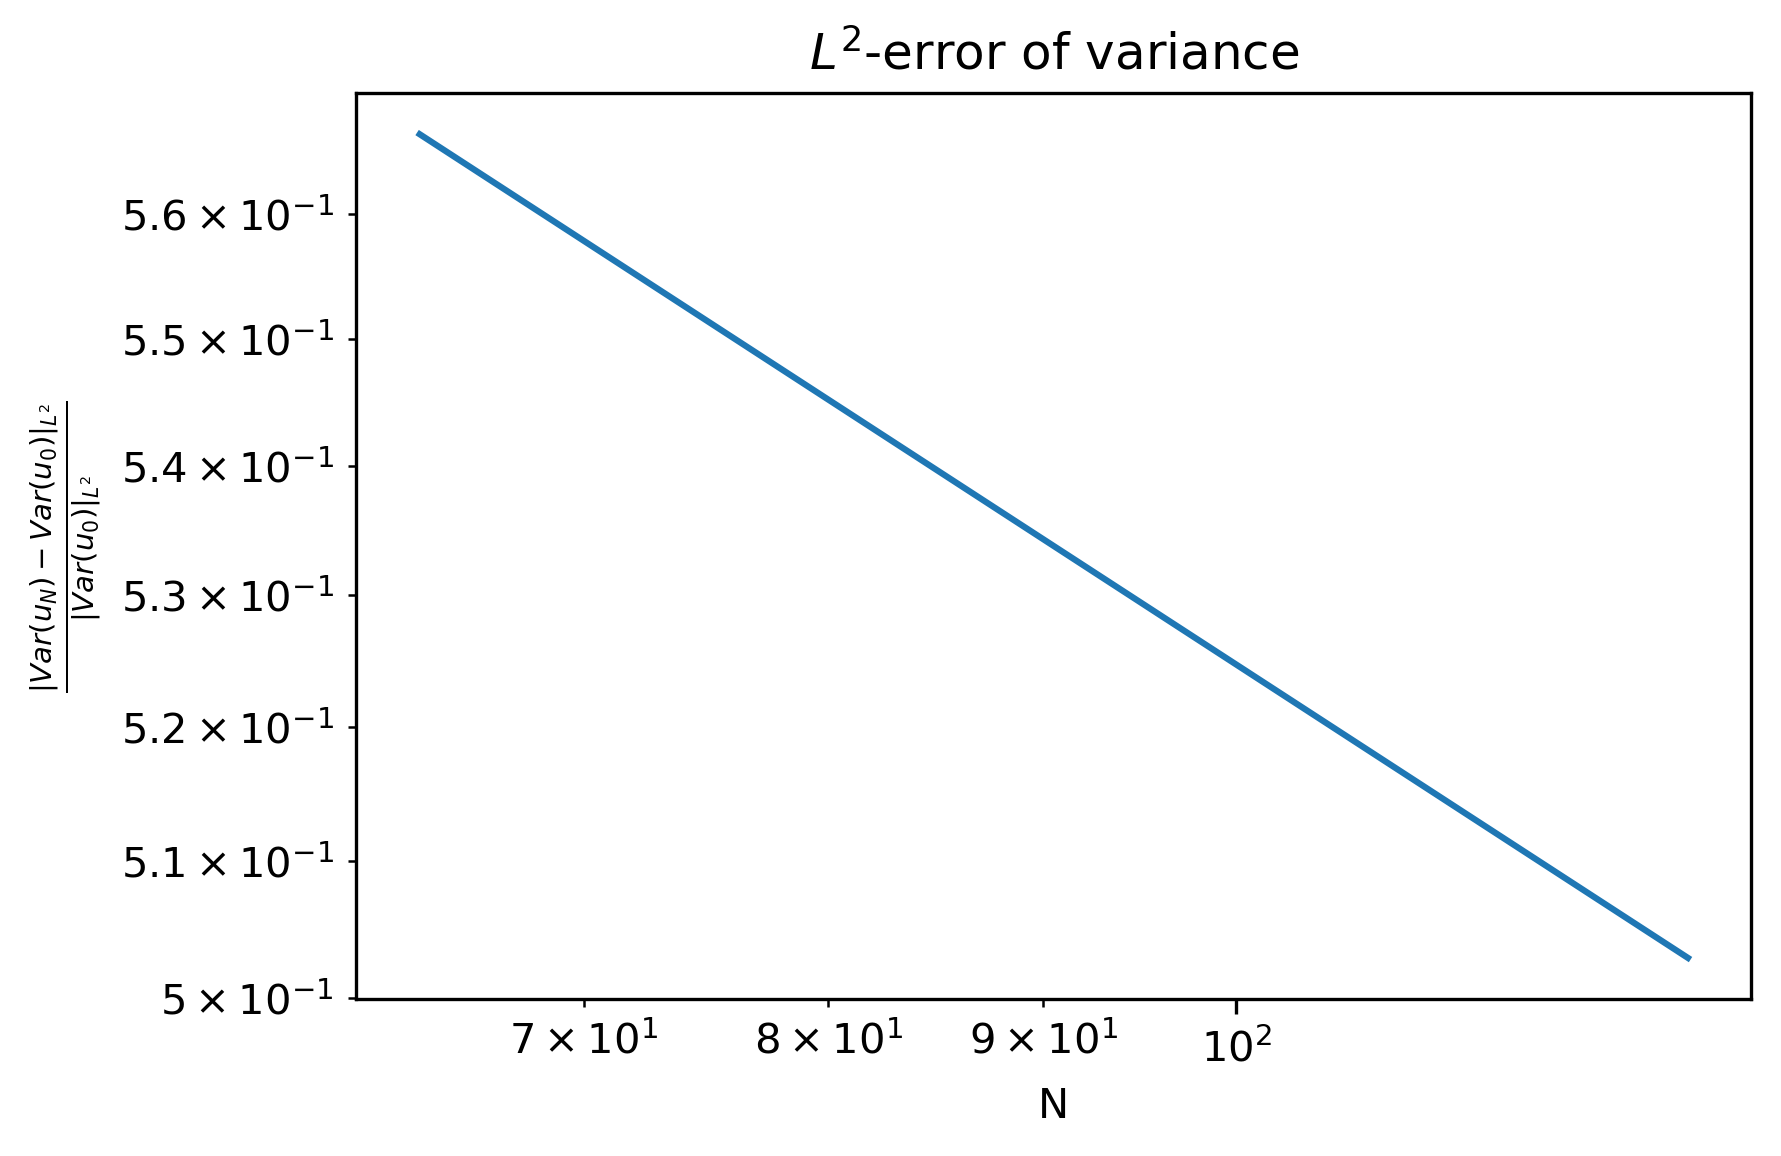

In [5]:
plot_mean([f'{experiment_folder}/tg_N64',
           f'{experiment_folder}/tg_N128',
           f'{experiment_folder}/tg_N256'],
          [64, 128, 256], 0,
          save_name=f'{experiment_folder}/tg_convergence_mean_t0.png')
plot_variance([f'{experiment_folder}/tg_N64',
               f'{experiment_folder}/tg_N128',
               f'{experiment_folder}/tg_N256'],
              [64, 128, 256], 0,
              save_name=f'{experiment_folder}/tg_convergence_variance_t0.png')
plot_mean([f'{experiment_folder}/tg_N64',
           f'{experiment_folder}/tg_N128',
           f'{experiment_folder}/tg_N256'],
          [64, 128, 256], 50,
          save_name=f'{experiment_folder}/tg_convergence_mean_t5.png')
plot_variance([f'{experiment_folder}/tg_N64',
               f'{experiment_folder}/tg_N128',
               f'{experiment_folder}/tg_N256'],
              [64, 128, 256], 50,
              save_name=f'{experiment_folder}/tg_convergence_variance_t5.png')

# Convergence of Discontinuous Shear Layer

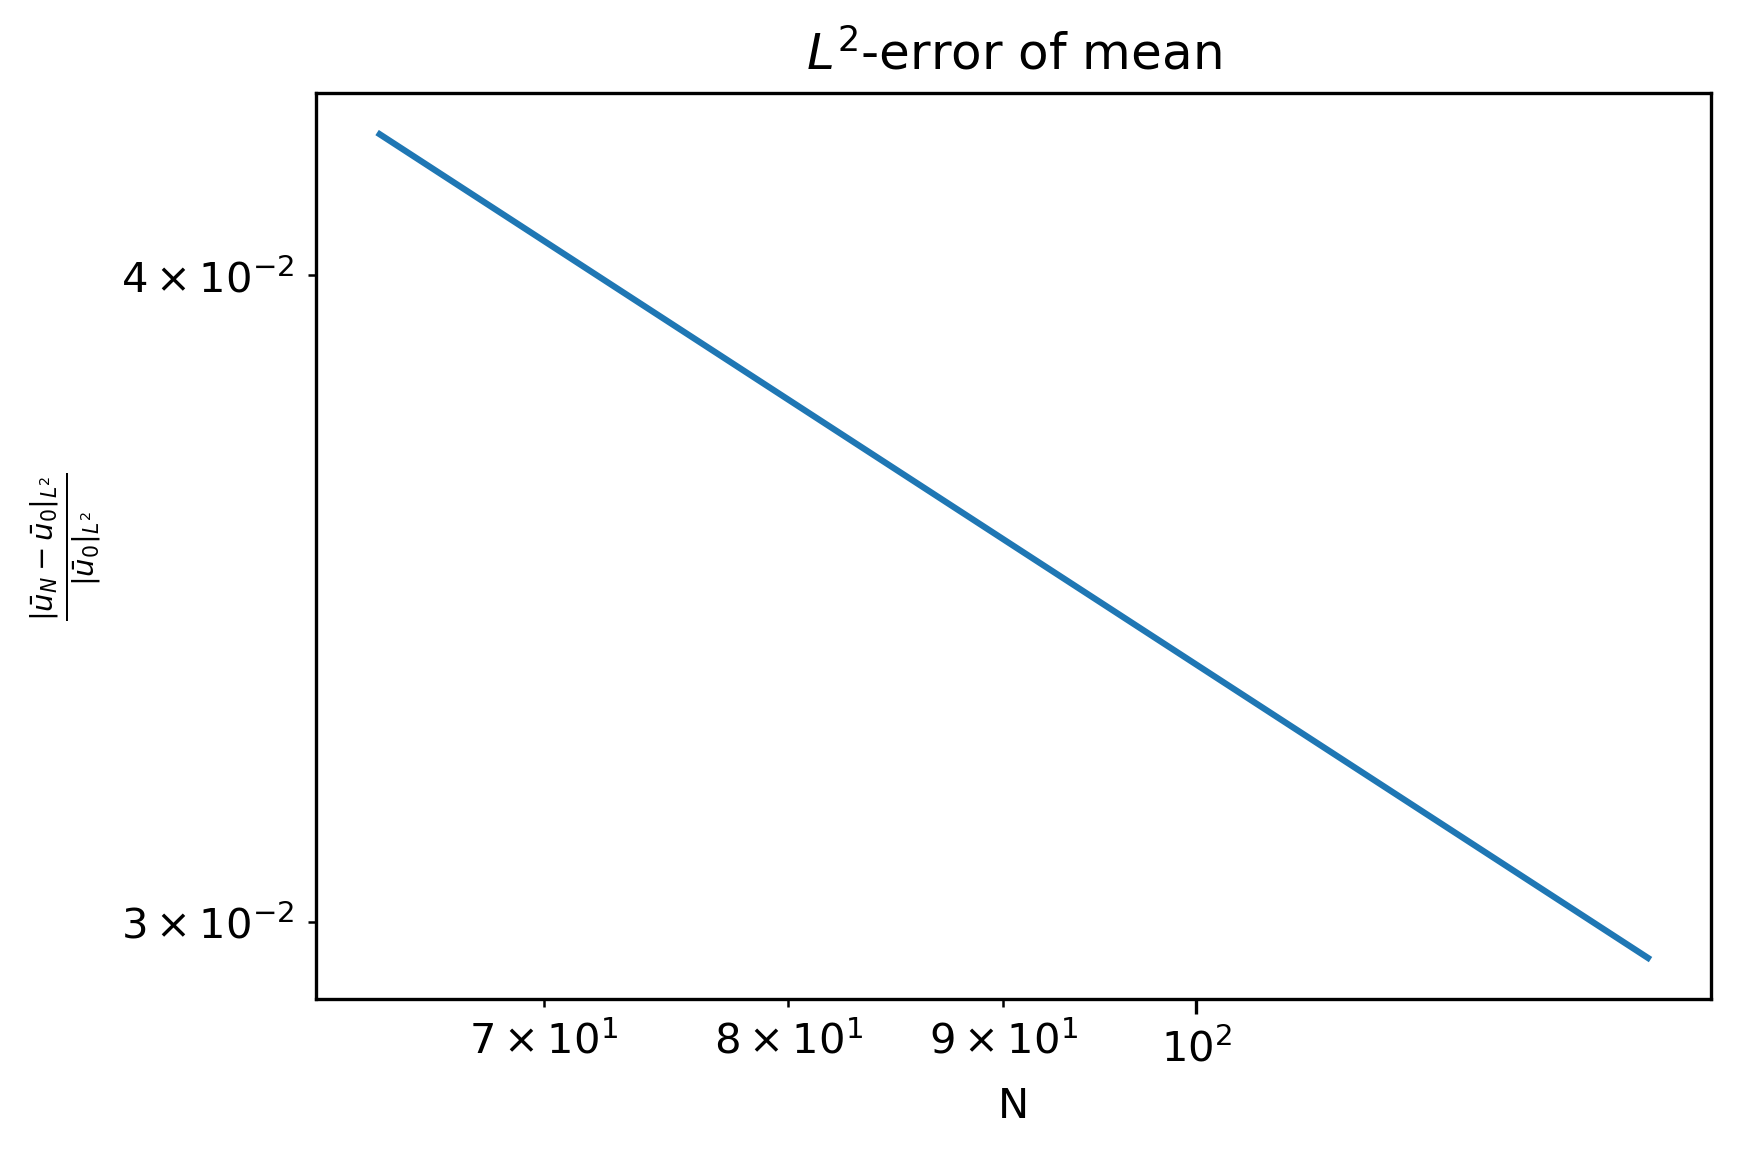

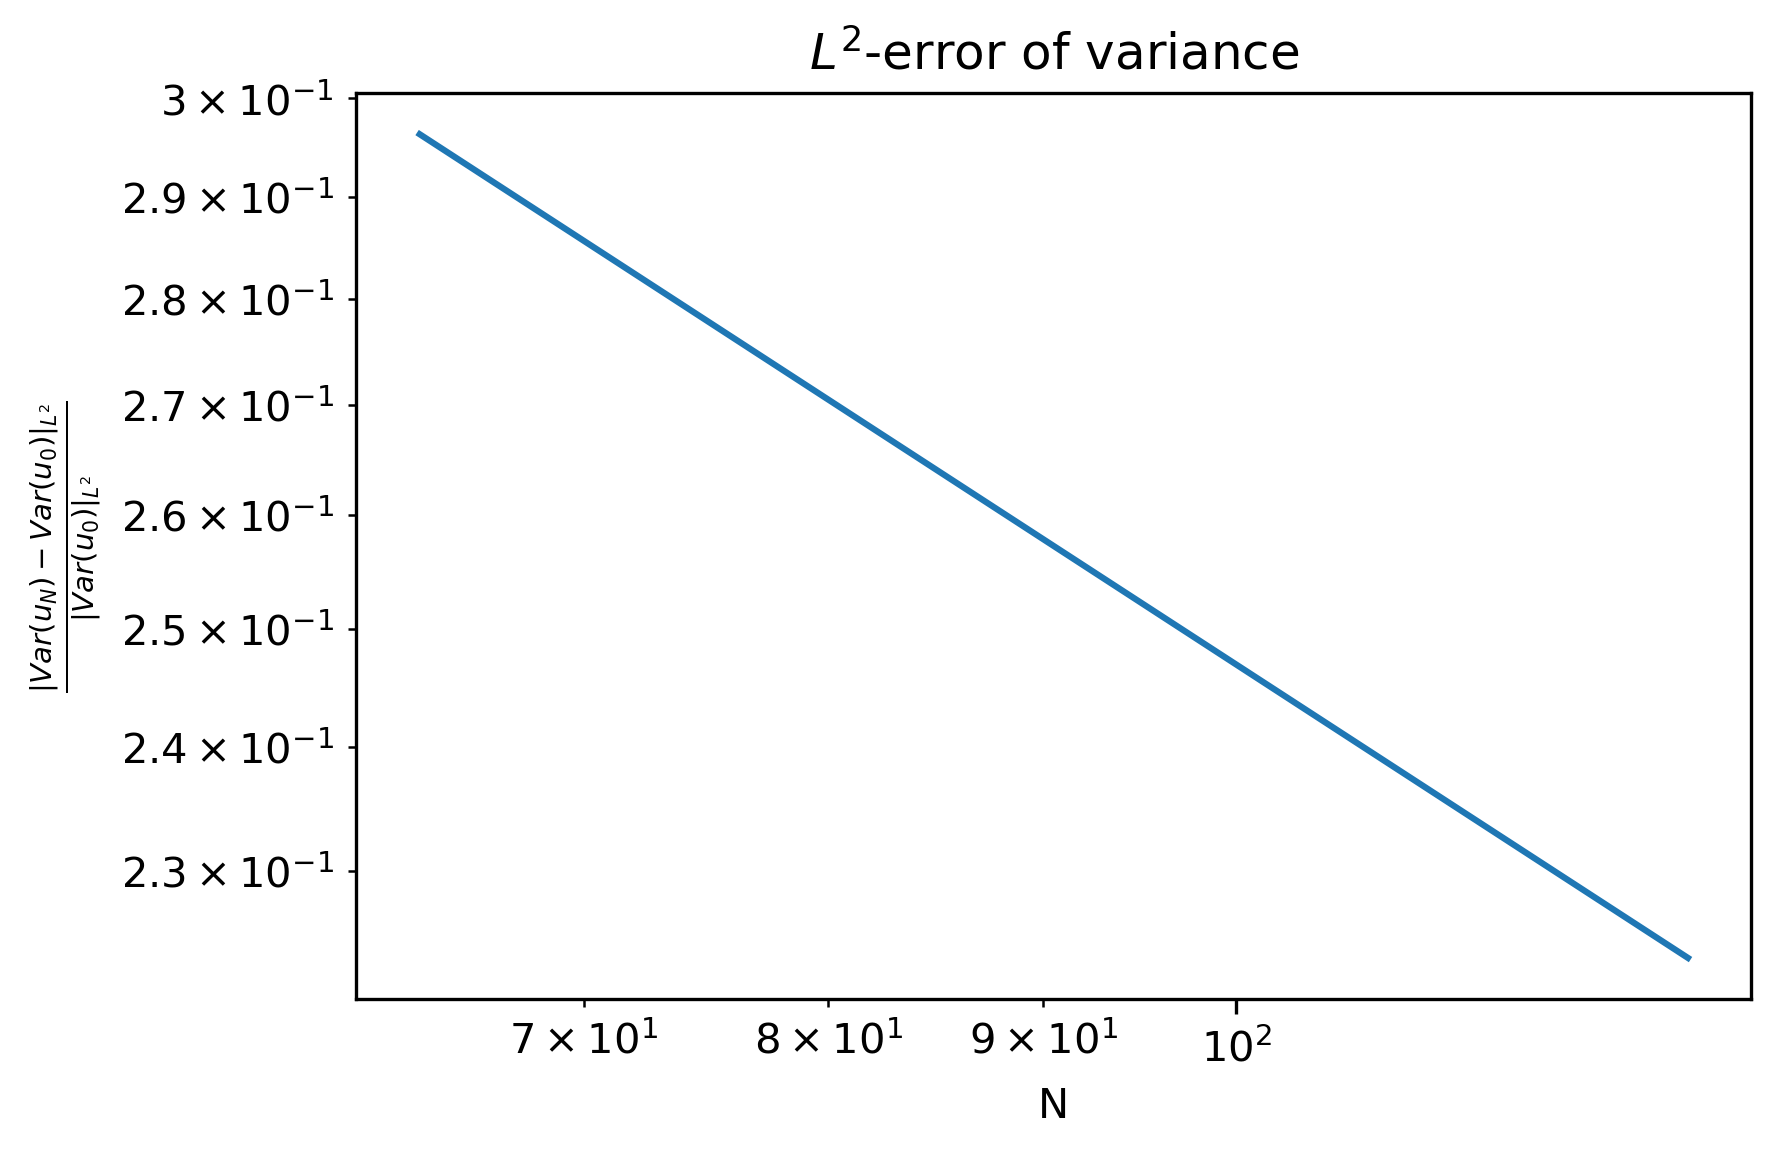

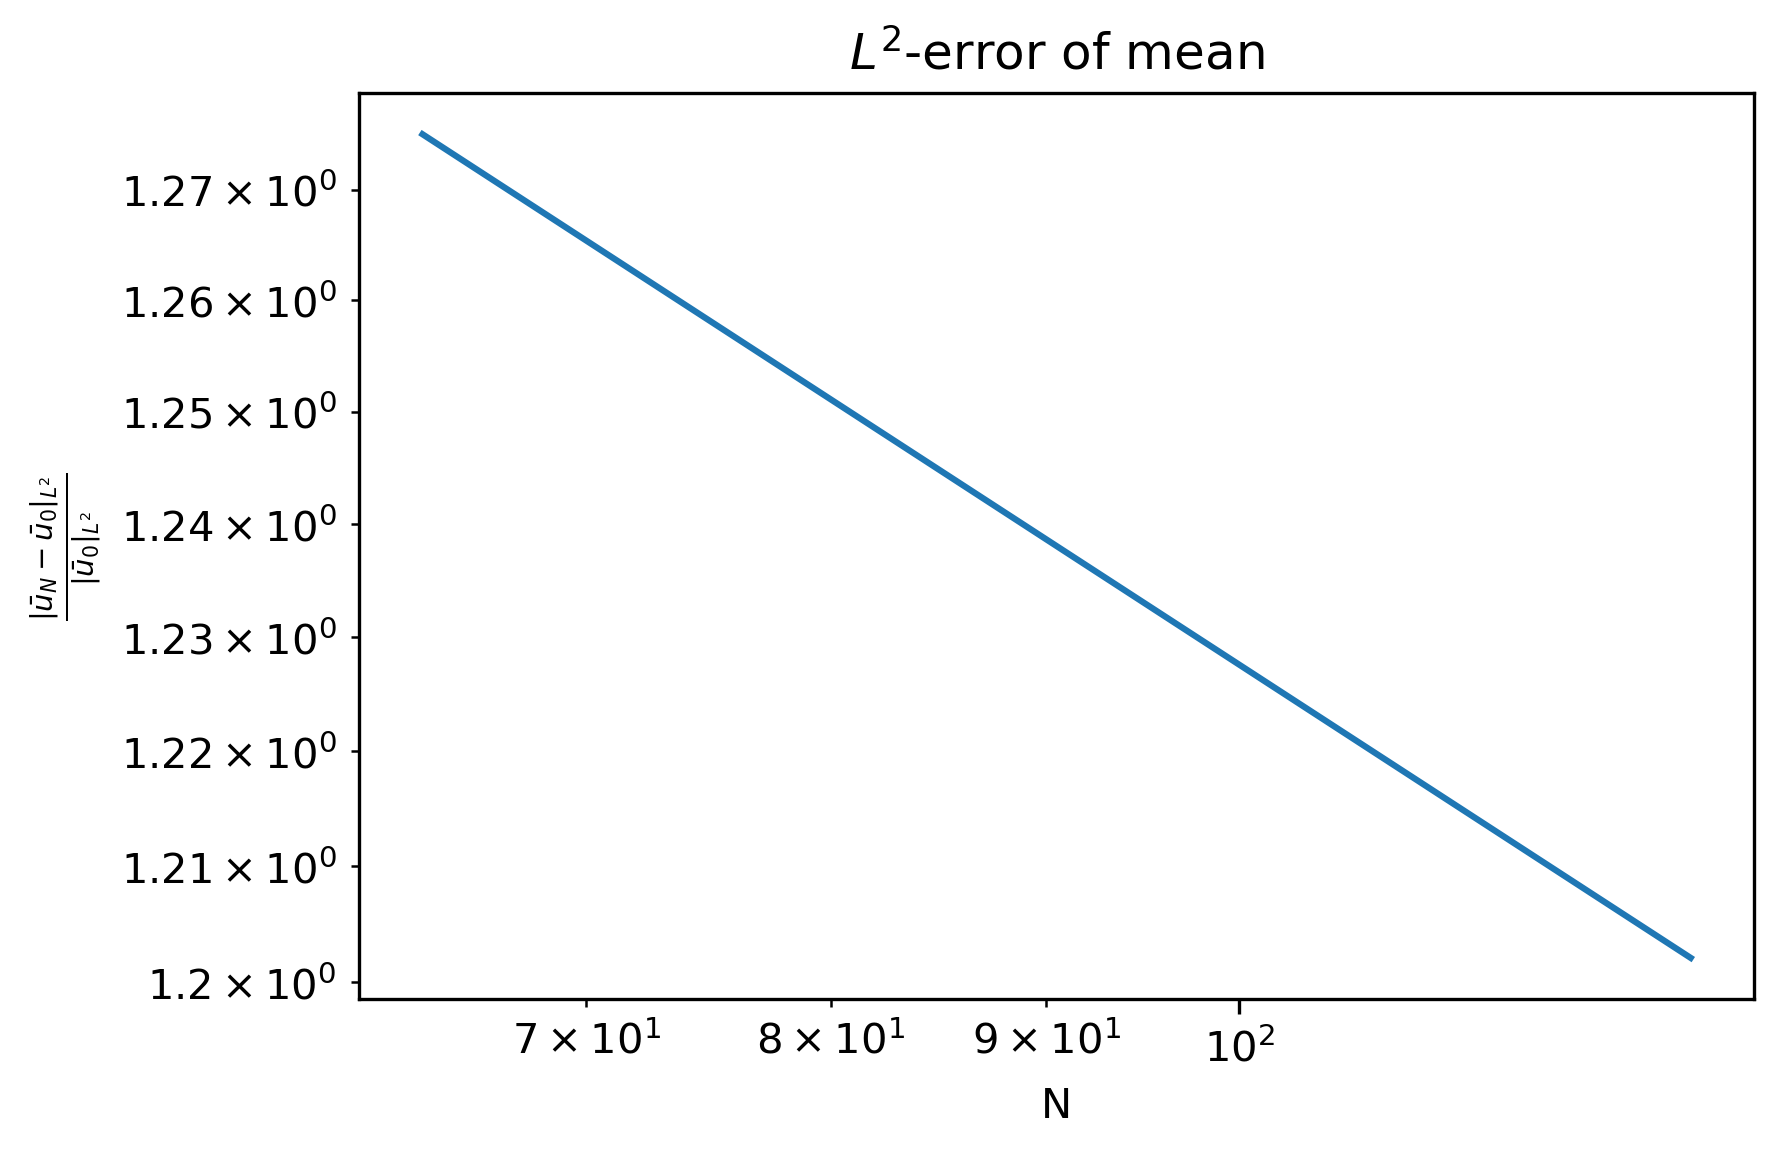

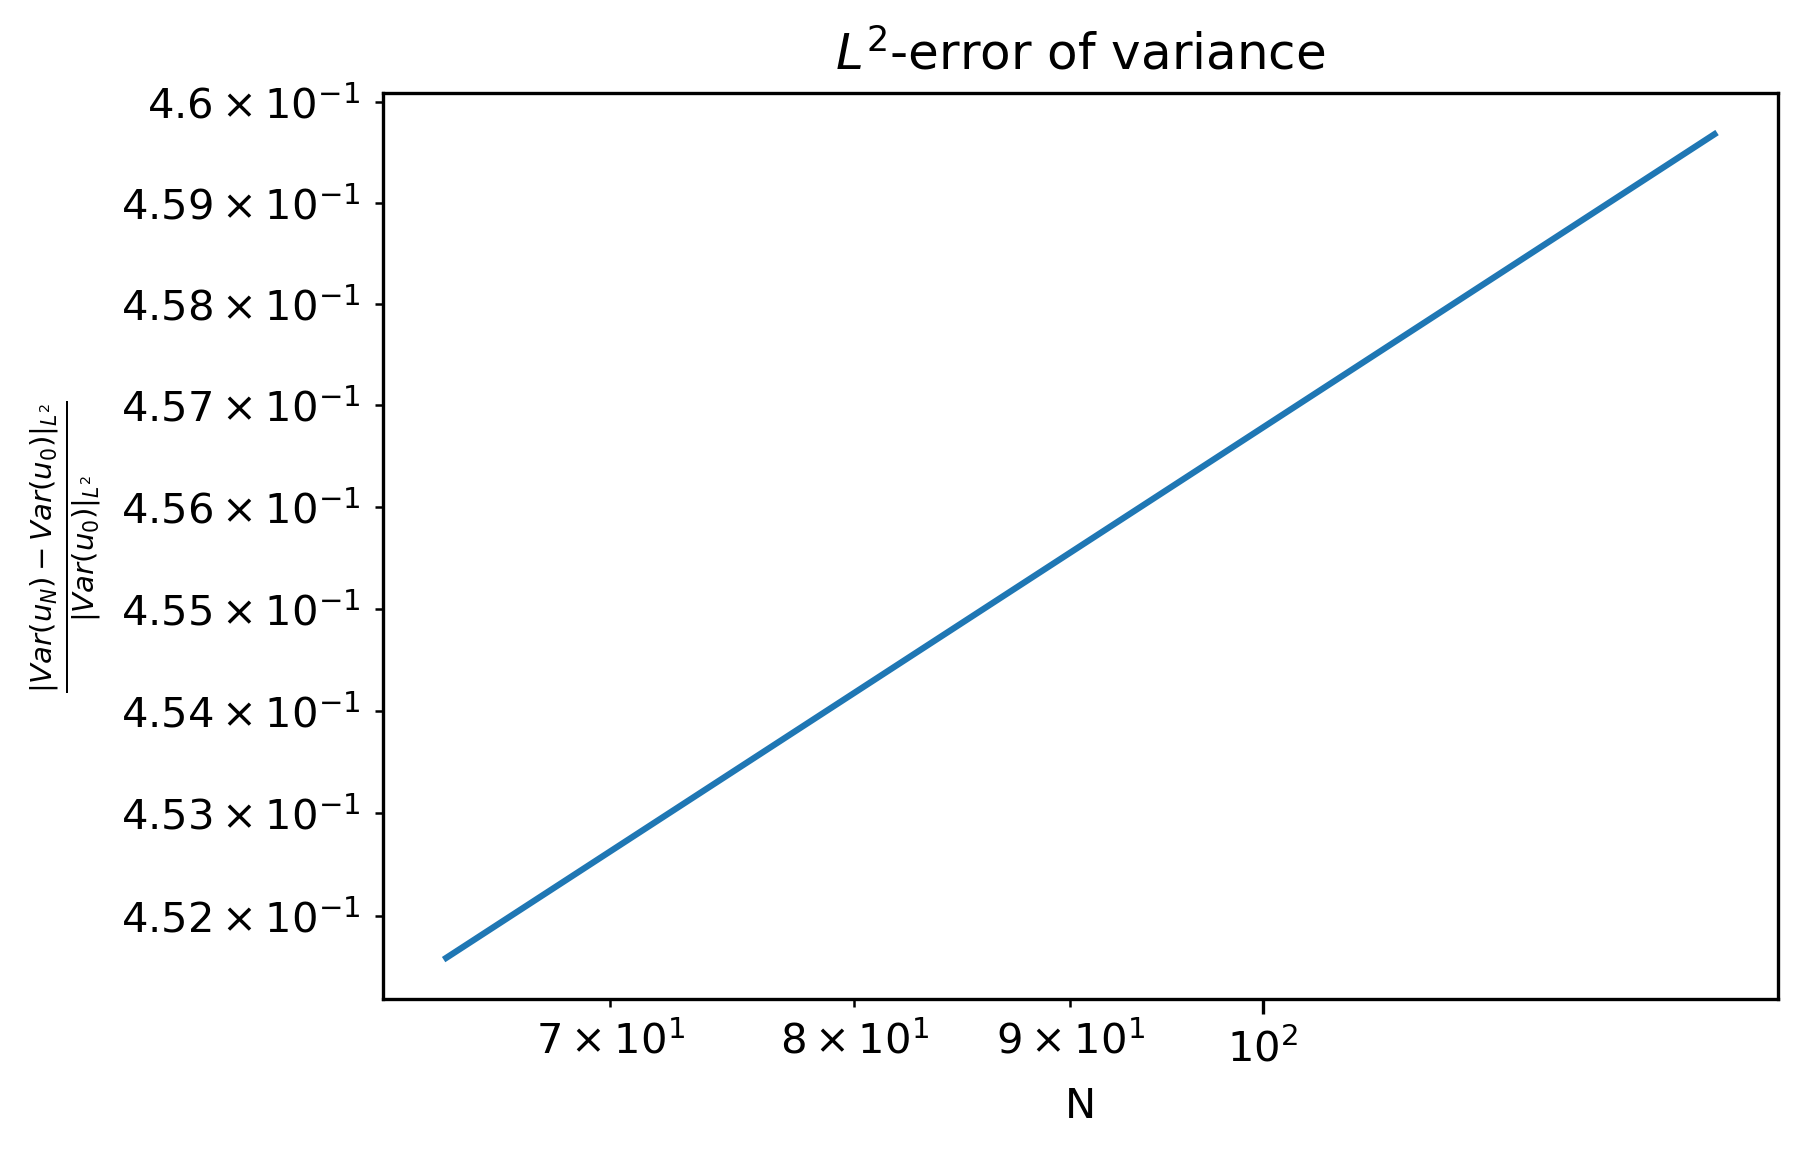

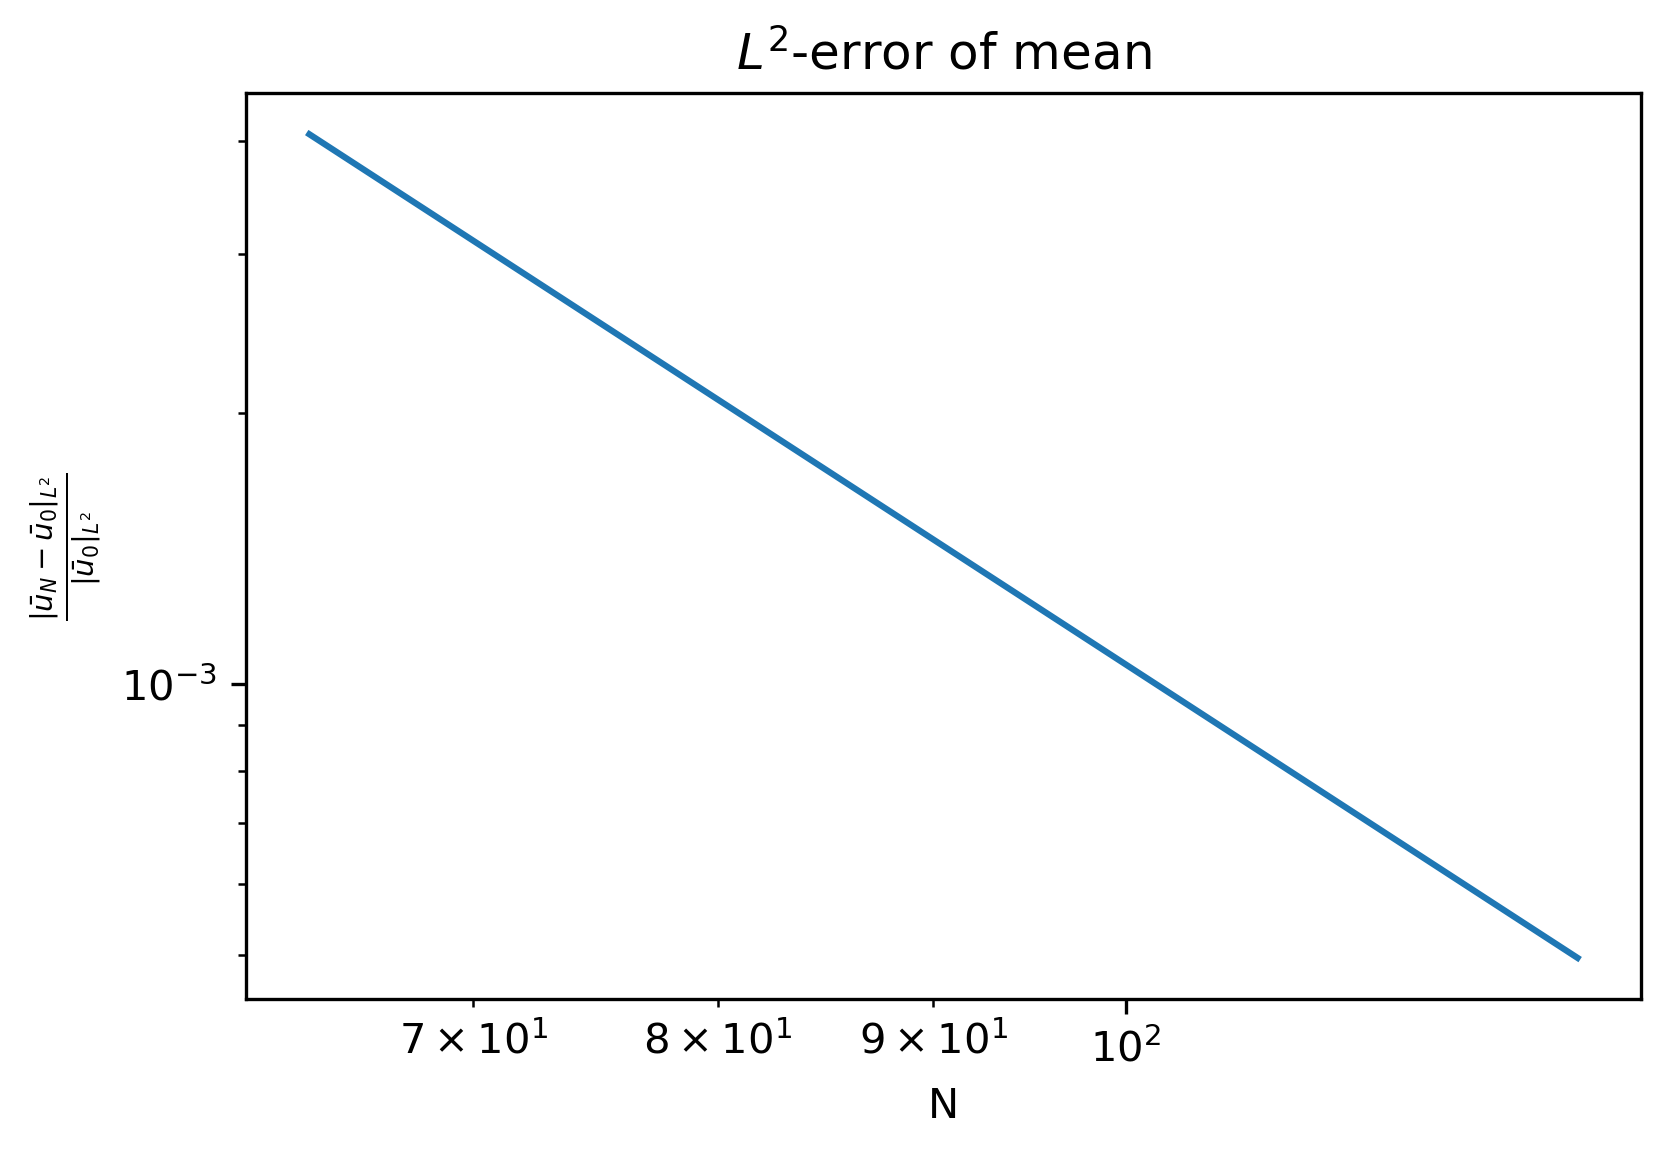

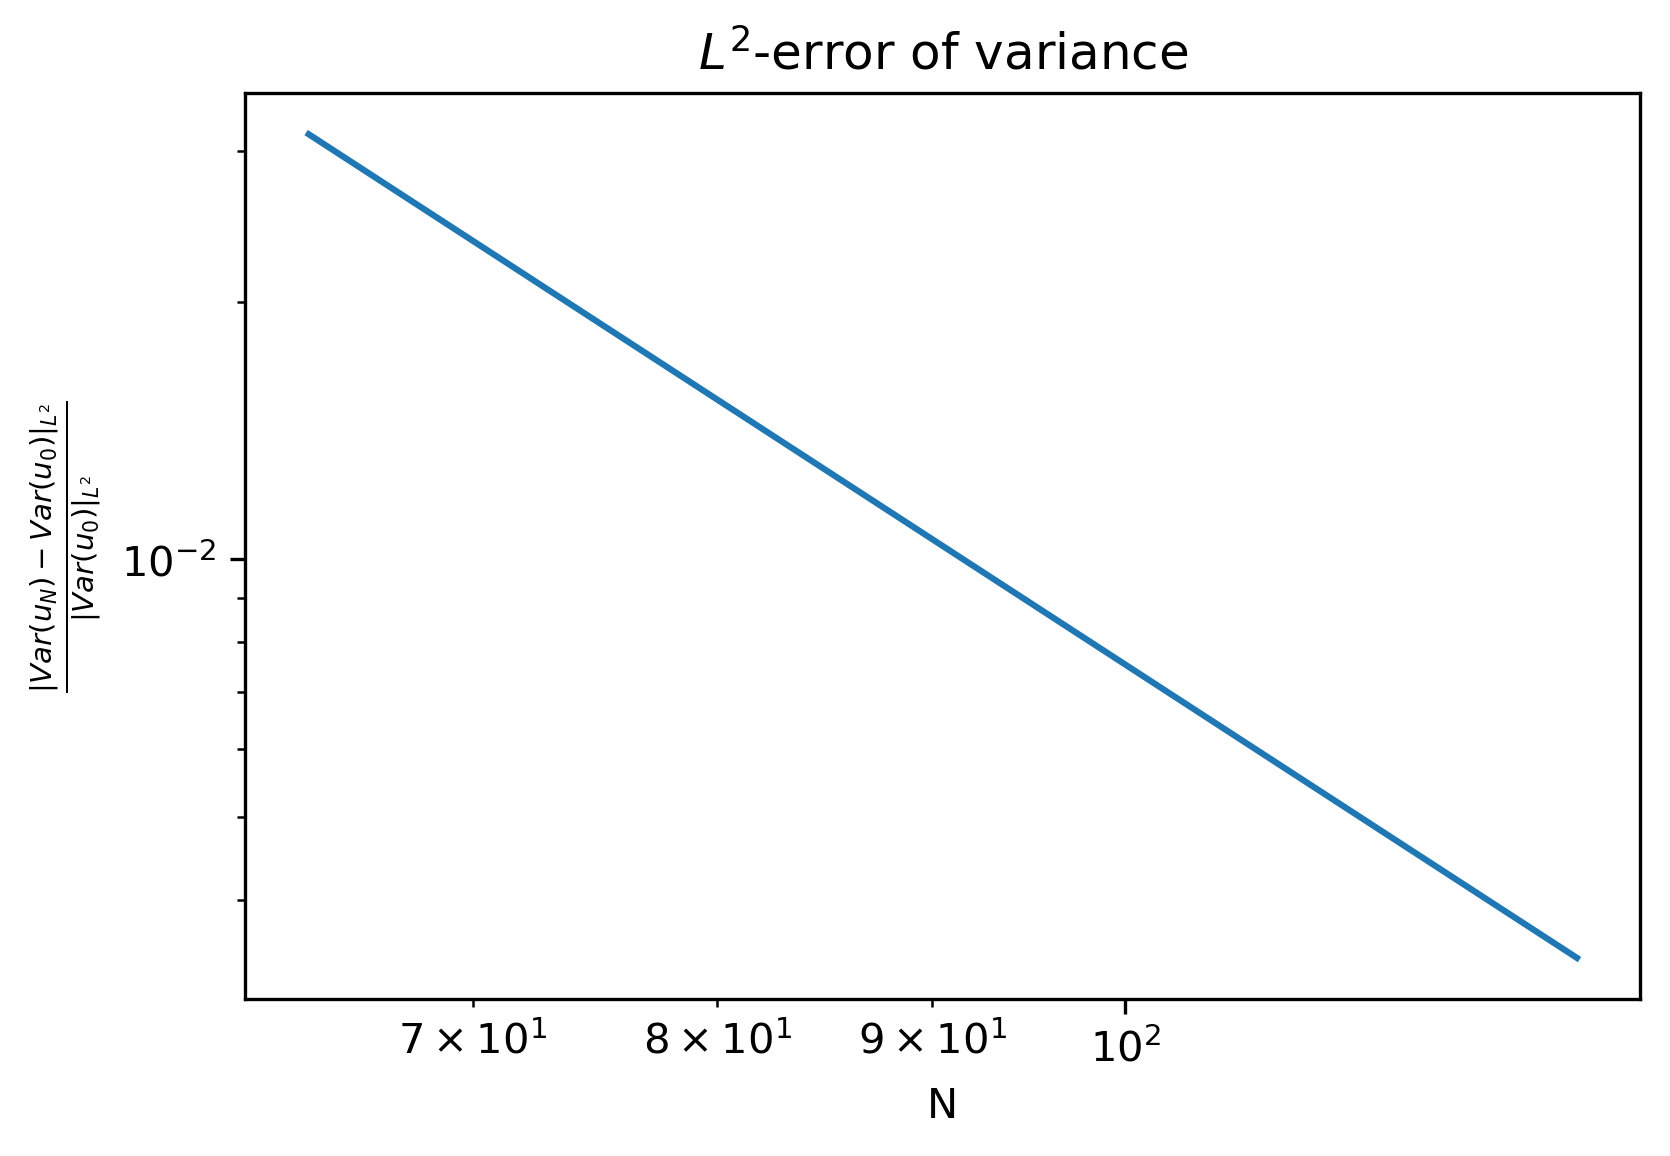

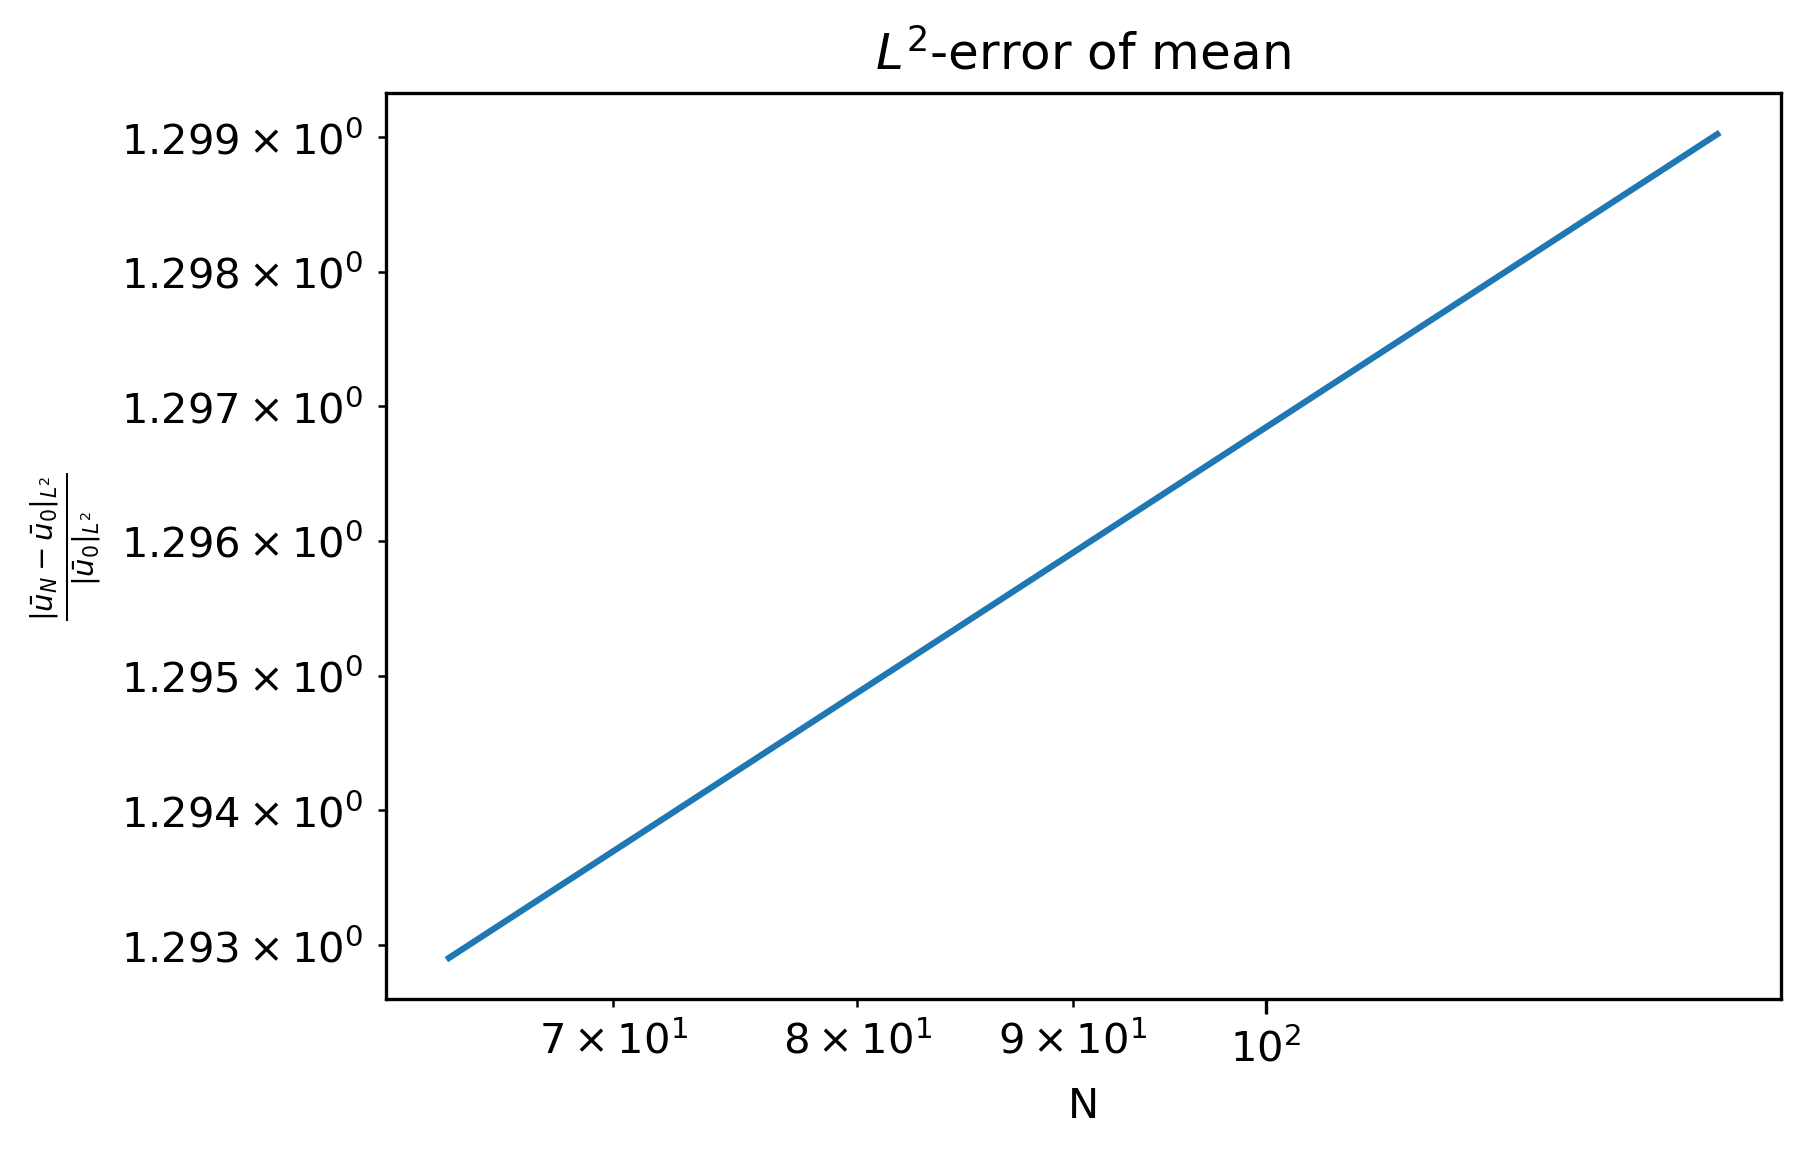

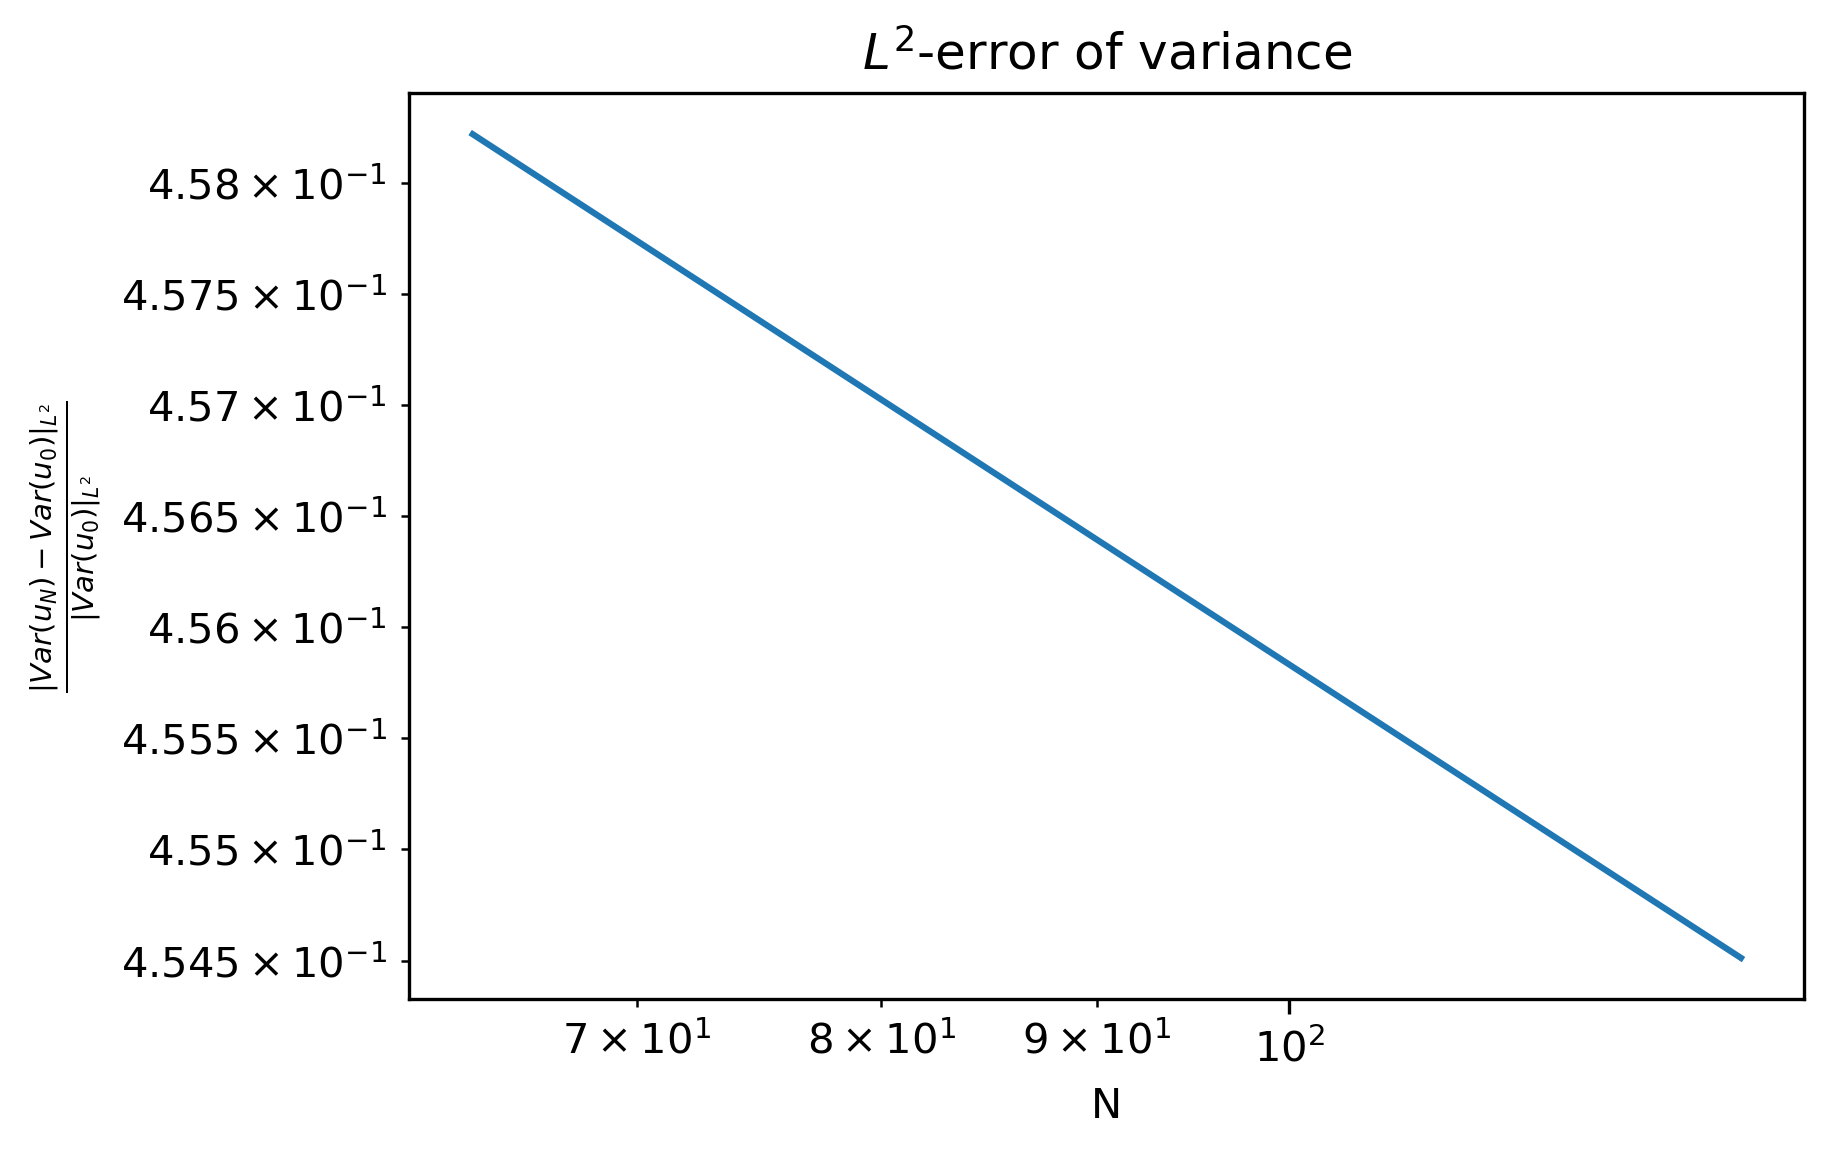

In [6]:
for rho in [0, 1]:
    plot_mean([f'{experiment_folder}/dst_r{rho}_N64',
               f'{experiment_folder}/dst_r{rho}_N128',
               f'{experiment_folder}/dst_r{rho}_N256'],
              [64, 128, 256], 0,
              save_name=f'{experiment_folder}/dst_r{rho}_convergence_mean_t0.png')
    plot_variance([f'{experiment_folder}/dst_r{rho}_N64',
                   f'{experiment_folder}/dst_r{rho}_N128',
                   f'{experiment_folder}/dst_r{rho}_N256'],
                  [64, 128, 256], 0,
                  save_name=f'{experiment_folder}/dst_r{rho}_convergence_variance_t0.png')
    plot_mean([f'{experiment_folder}/dst_r{rho}_N64',
               f'{experiment_folder}/dst_r{rho}_N128',
               f'{experiment_folder}/dst_r{rho}_N256'],
              [64, 128, 256], 50,
              save_name=f'{experiment_folder}/dst_r{rho}_convergence_mean_t5.png')
    plot_variance([f'{experiment_folder}/dst_r{rho}_N64',
                   f'{experiment_folder}/dst_r{rho}_N128',
                   f'{experiment_folder}/dst_r{rho}_N256'],
                  [64, 128, 256], 50,
                  save_name=f'{experiment_folder}/dst_r{rho}_convergence_variance_t5.png')